In [1]:
import pandas as pd
import numpy as np
import math
from itertools import cycle, product

import statistics
import shap


#from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import style
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
import shap

from scipy.stats import randint, uniform, shapiro
import scikitplot as skplt
import sklearn as sk
from sklearn import linear_model

from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, PowerTransformer, OneHotEncoder
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as ltb
import xgboost as xgb
import pmdarima as pm

import statsmodels.api as sm
import statsmodels
import statsmodels.stats.api as sms
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
import statsmodels.tsa.api as smt
from statsmodels.tools import eval_measures
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_white, het_arch
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller


from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from fredapi import Fred
import pandas_datareader as pdr

import warnings

In [2]:
sk.set_config(display='diagram')
warnings.filterwarnings("ignore")
shap.initjs()

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
plt.rcParams["figure.figsize"] = (10,6)

# Plotting using Seaborn
sns.set(style="whitegrid")
style.use("seaborn-white")

In [3]:
fred = Fred(api_key='c0a3f23bdd23a65e6546b6d0e5f4d4a5')

In [4]:
from common.load_features import get_recession, add_recession_feature, get_fed_chair, add_fed_chair
from common.load_data import load_taylor,load_misery, time_split
from common.calc_metrics import model_results
from common.LinearRegDiagnostic import LinearRegDiagnostic

# Setup

## variables

In [5]:
rand_int = 12

#  Set start date
start_date = datetime.date(1940, 1, 1)
start_date_str = datetime.datetime.strftime(start_date, "%Y-%m-%d")

#  Federal Reserve Economic Data Service
data_source = 'fred'

# Explore

In [103]:
t_df = load_taylor()
m_df = load_misery()
chair_df = get_fed_chair()

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)
t_df: (832, 3)
u_df: (909, 1)
misery_df: (825, 6)


In [105]:
m_df[['FEDFUNDS_diff','FEDFUNDS','m_index']]

,FEDFUNDS_diff,FEDFUNDS,m_index
DATE,,,
1955-01-01,0.1100,1.3900,4.2690
1955-02-01,-0.1000,1.2900,4.0701
1955-03-01,0.0600,1.3500,4.0801
1955-04-01,0.0800,1.4300,4.4394
1955-05-01,0.0000,1.4300,3.7059
...,...,...,...
2023-05-01,0.2300,5.0600,7.8288
2023-06-01,0.0200,5.0800,6.6920
2023-07-01,0.0400,5.1200,6.7991


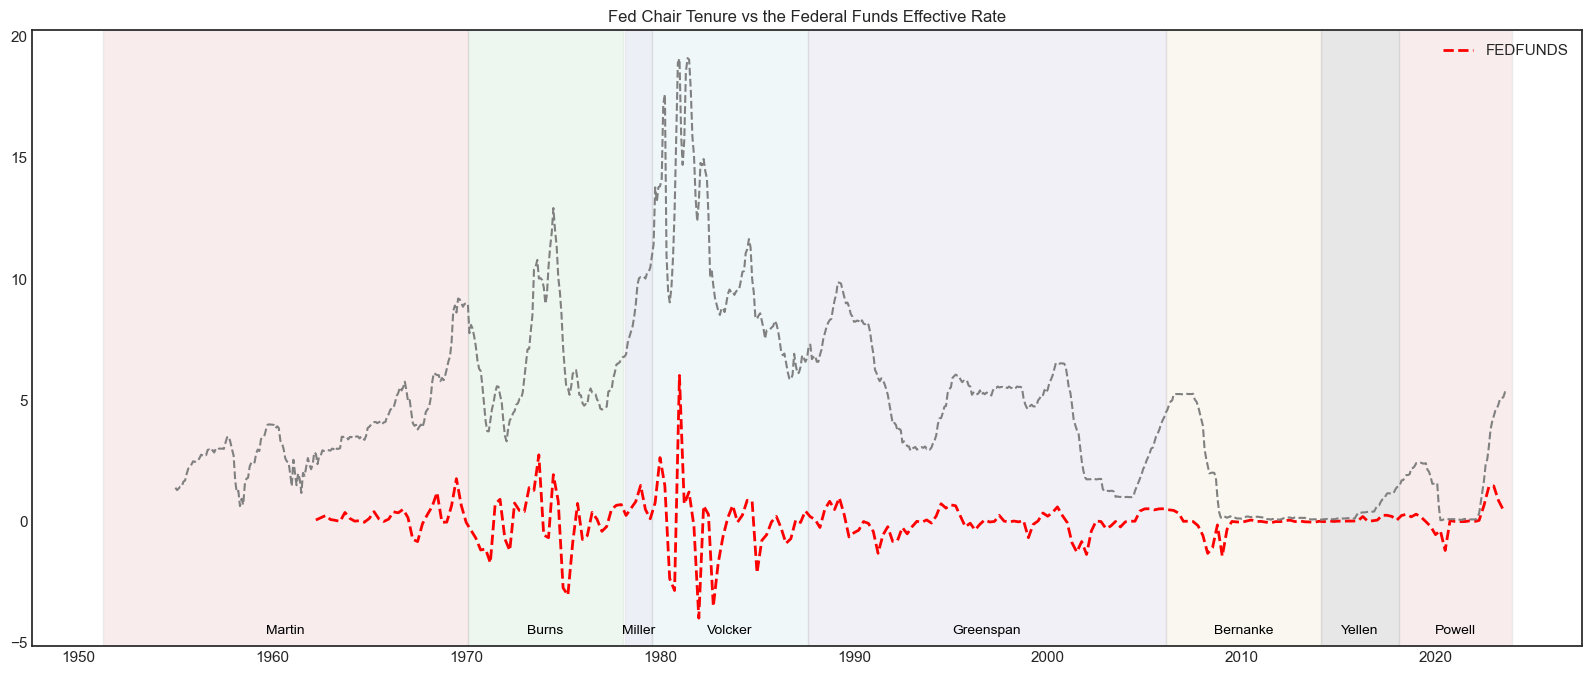

In [8]:
cycol = cycle('rgbcmyk')
min_value = m_df[['FEDFUNDS_diff','FEDFUNDS','m_index']].values.min() + 2


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS_diff'], color='red', linestyle='--',linewidth=2)
ax.plot(m_df.index, m_df['FEDFUNDS'], linestyle='--', color='gray',linewidth=1.5) 
    
# Plotting Chair Tenure
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS"])
#plt.legend()
plt.grid(False)
ax.set(title='Fed Chair Tenure vs the Federal Funds Effective Rate');
plt.show()

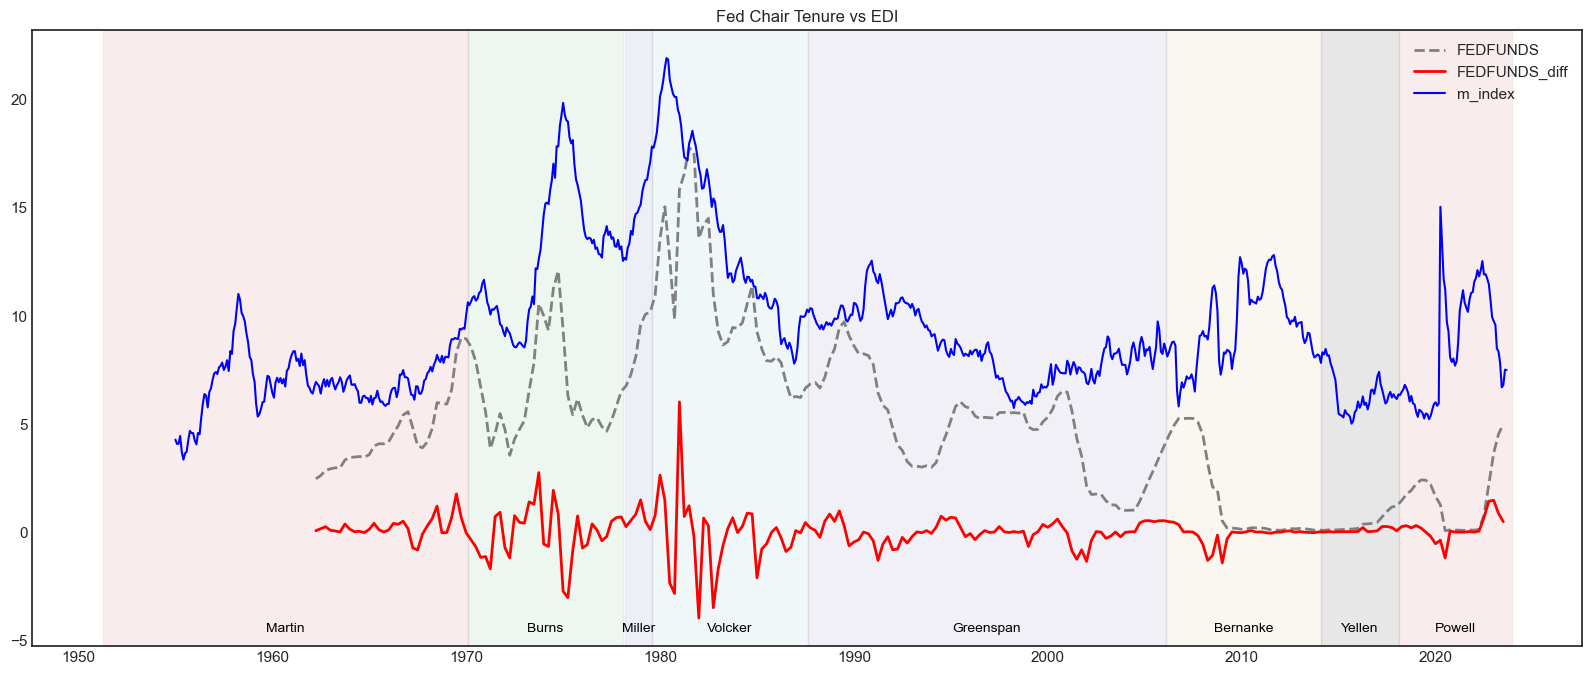

In [9]:
cycol = cycle('rgbcmyk')
min_value = m_df[['FEDFUNDS_diff','FEDFUNDS','m_index']].values.min() + 2


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'], linestyle='--',color='gray',linewidth=2)
ax.plot(t_df.index, t_df['FEDFUNDS_diff'], color='red',linewidth=2)
ax.plot(m_df.index, m_df['m_index'],  color='blue',linewidth=1.5) 
    
# Plotting Chair Tenure
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","FEDFUNDS_diff","m_index"])
ax.set(title='Fed Chair Tenure vs EDI');
plt.show()

In [99]:
t_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS_CPIAUCNS_PC1', 'FEDFUNDS-1', 'FEDFUNDS_diff',
       'FEDFUNDS_CPIAUCNS_PC1-1', 'FEDFUNDS_CPIAUCNS_PC1_diff', 'gap_inf',
       'gap_gdp', 'gap_ue', 'ffef_tr', 'ffef_tr2', 'ffef_tr_diff',
       'ffef_tr2_diff', 'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

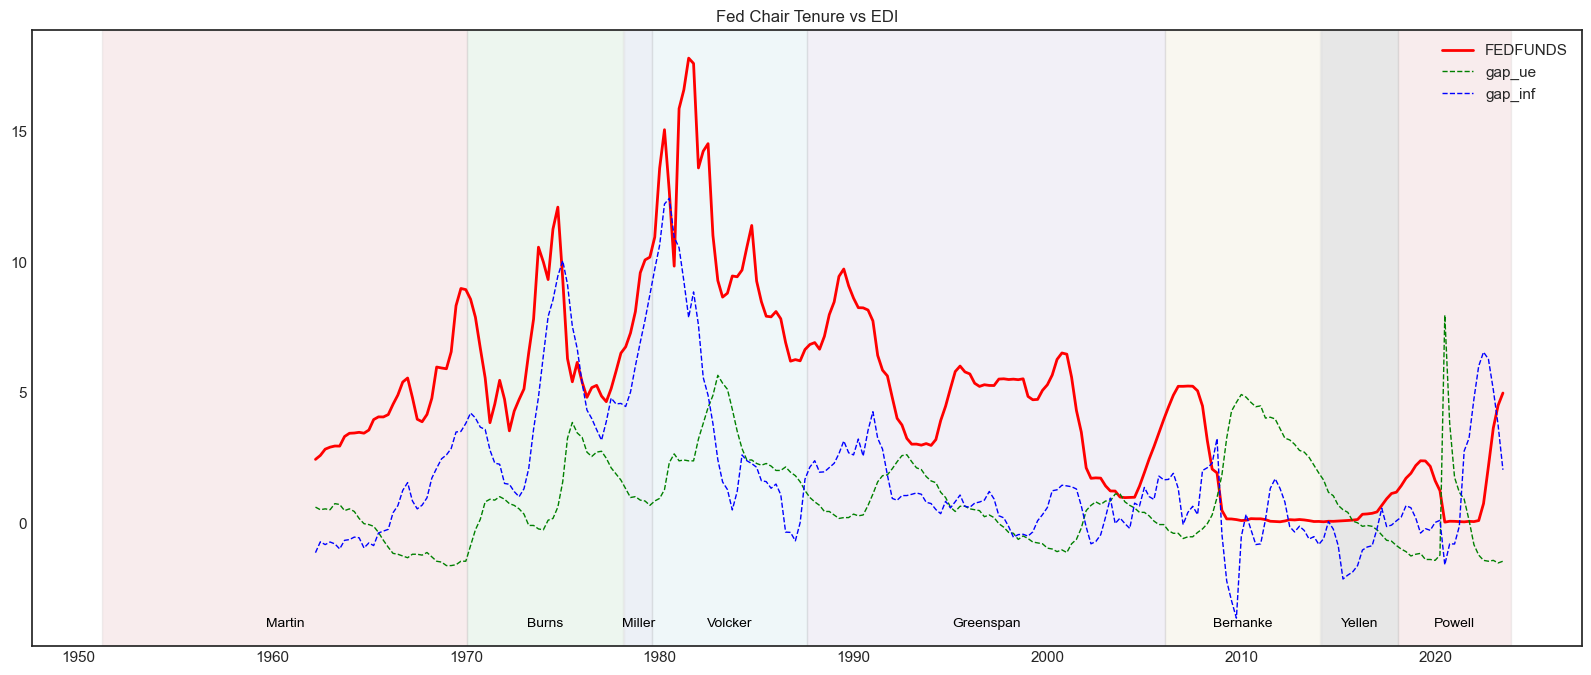

In [108]:
cycol = cycle('rgbcmyk')
min_value = m_df[['FEDFUNDS']].values.min() - 4


# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(t_df.index, t_df['FEDFUNDS'],color='red',linewidth=2)
ax.plot(t_df.index, t_df['gap_ue'], linestyle='--', color='green',linewidth=1)
ax.plot(t_df.index, t_df['gap_inf'], linestyle='--', color='blue',linewidth=1)
    
# Plotting Chair Tenure
for i,row in chair_df.query('End_Date >= "1960-01-01"').iterrows():
    plt.axvspan(row['Start_Date'], row['End_Date'], facecolor=next(cycol), edgecolor='gray', alpha=0.1, label=row['Name'])
    midpoint = row['Start_Date'] + (row['End_Date'] - row['Start_Date']) / 2
    plt.text(midpoint, min_value, row['Name'],fontsize=10, color='black', ha='center')
    
    
ax.legend(["FEDFUNDS","gap_ue","gap_inf"])
ax.set(title='Fed Chair Tenure vs EDI');
plt.show()

In [10]:
t_df[['FEDFUNDS','UNRATE','GDPDEF_PC1','gap_inf','gap_gdp','gap_ue','chair_name','Real_Interest_Rate','chair_index']].groupby('chair_name').mean().round(2).sort_values(by='chair_index')

,FEDFUNDS,UNRATE,GDPDEF_PC1,gap_inf,gap_gdp,gap_ue,Real_Interest_Rate,chair_index
chair_name,,,,,,,,
Martin,4.5800,4.4400,2.5800,0.6000,9.4600,-0.5600,4.8500,8.0000
Burns,6.4900,6.2800,6.2600,4.5100,6.5300,1.2800,3.8000,9.0000
Miller,8.6600,5.9700,7.3300,6.5000,8.6200,0.9700,3.6200,10.0000
Volcker,10.6900,7.7500,5.3500,4.3300,4.4900,2.7500,3.5300,11.0000
Greenspan,4.8200,5.5400,2.4300,1.0900,6.8600,0.5400,3.0600,12.0000
Bernanke,1.5700,7.2900,1.9000,0.2400,5.0000,2.2900,1.3100,13.0000
Yellen,0.4000,5.1700,1.3500,-0.7200,5.8000,0.1700,0.6600,14.0000
Powell,1.5500,4.8100,3.4800,1.7500,7.3200,-0.1900,0.9400,15.0000


In [11]:
m_df.reset_index(inplace=True)

m_df['chair_name'] = None
m_df['chair_index'] = 0
for i, row in chair_df.iterrows():
    m_df['chair_name'] = m_df['chair_name'].where((m_df['DATE'] < row['Start_Date']) | (m_df['DATE'] > row['End_Date']), row['Name'] )
    m_df['chair_index'] = m_df['chair_index'].where((m_df['DATE'] < row['Start_Date']) | (m_df['DATE'] > row['End_Date']), i )

m_df.set_index('DATE',inplace=True)

In [12]:
df = m_df[['FEDFUNDS','UNRATE','CPIAUCSL_PC1','m_index','chair_name']].groupby('chair_name').mean().round(2).sort_values(by='m_index', ascending=False)
df

,FEDFUNDS,UNRATE,CPIAUCSL_PC1,m_index
chair_name,,,,
Miller,9.2400,5.8900,9.2300,15.1200
Volcker,10.6100,7.7500,6.1700,13.9300
Burns,6.4700,6.3100,6.5200,12.8200
Bernanke,1.5300,7.3100,2.2200,9.5200
Greenspan,4.8000,5.5300,3.0900,8.6200
Powell,1.7200,4.7800,3.7900,8.5700
Martin,3.6500,4.8500,2.1300,6.9800
Yellen,0.4600,5.0600,1.3200,6.3800


# Functions

In [13]:
train0_df = load_taylor()

model_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
#model_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, model_stats_df)
                              
model_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, model_stats_df )
#model_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, model_stats_df )                         

model_stats_df

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)


,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,31.7498,5.6347,9.9857,4.9215,0
1,ffef_tr2_train,0.9629,0.9813,0.8930,0.6269,0


model_stats_df = model_results('Naive_test', train0_df['FEDFUNDS'], train0_df['FEDFUNDS-1'], train0_df.shape[0], 1  , None )
model_stats_df = model_results('Naive_test', test0_df['FEDFUNDS'], test0_df['FEDFUNDS-1'], test0_df.shape[0], 1  , model_stats_df )

# Load Data

In [14]:
taylor_df = load_taylor()
#taylor_df = taylor_df.query('DATE >= "2000-01-01"').copy()
#taylor_df = taylor_df.query('DATE >= "1990-01-01" & DATE < "2007-01-01"').copy()
#taylor_df = taylor_df.query('DATE < "2007-01-01"').copy()
train_df = taylor_df
#train_df, test_df = time_split(taylor_df)

t1_df: (1007, 4)
gdpc1_df: (305, 2)
gdppot_df: (304, 2)
gdpdef_df: (302, 2)
cpi_df: (909, 2)
holston_df: (250, 4)
ff_cpi_df: (832, 2)


In [15]:
#taylor_df['chair_name'].unique()
taylor_df.columns

Index(['FEDFUNDS', 'UNRATE', 'TB3MS', 'GDPC1', 'GDPPOT', 'GDPDEF_PC1',
       'CPIAUCSL_PC1', 'Growth_g', 'Real_Interest_Rate', 'Output_Gap',
       'FEDFUNDS_CPIAUCNS_PC1', 'FEDFUNDS-1', 'FEDFUNDS_diff',
       'FEDFUNDS_CPIAUCNS_PC1-1', 'FEDFUNDS_CPIAUCNS_PC1_diff', 'gap_inf',
       'gap_gdp', 'gap_ue', 'ffef_tr', 'ffef_tr2', 'ffef_tr_diff',
       'ffef_tr2_diff', 'recession_flag', 'chair_name', 'chair_index'],
      dtype='object')

# Case

In [16]:
#test_df[['FEDFUNDS-1', 'gap_inf', 'gap_ue','gap_gdp','recession_flag', 'CPIAUCSL_PC1']]

In [17]:
#case = 1  # Full Model
case = 2  # Modified Taylor Rule
#case = 3  # Modified Taylor Rule
#case = None  # Feature Selection

# Initialize Variables
X_train = None
y_train = None
X_test = None
y_test = None

# Initialize Imputer
preprocessor = None




if case == 1:
    
    print('-- Full Model')
    X_train = train_df[['gap_inf','gap_ue','CPIAUCSL_PC1','UNRATE']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']



    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()

    # Initialize Transformer / OneHotEncoder
    #num_columns_lst = ['FEDFUNDS-1', 'gap_inf', 'gap_ue','Real_Interest_Rate']
    num_columns_lst = ['gap_inf','gap_ue','CPIAUCSL_PC1','UNRATE']
    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
        ]
    )   
    
elif case == 2:
    print('-- Federal Reserve')
    X_train = train_df[['gap_inf', 'gap_ue','recession_flag','FEDFUNDS-1','chair_name']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag','chair_name']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )   

elif case == 3:
    print('-- Federal Reserve')
    X_train = train_df[['gap_inf', 'gap_ue','FEDFUNDS-1','chair_name']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']


    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['chair_name']
    num_columns_lst = ['gap_inf', 'gap_ue','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )   
    
else:
    print('-- All Variables')
    X_train = train_df[['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','recession_flag','FEDFUNDS-1']] 
    #X_train = X_train + 10
    y_train = train_df['FEDFUNDS']

    # Initialize Imputer
    imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler_num = RobustScaler()
    #scaler_num = StandardScaler()
    #scaler_num = Normalizer()
    #scaler_num = PowerTransformer()
    #scaler_num = PowerTransformer(method='box-cox')
    #scaler_num = FunctionTransformer(np.log1p, validate=True)
    #scaler_num = QuantileTransformer(random_state=rand_int)

    # Initialize Transformer / OneHotEncoder
    cat_columns_lst = ['recession_flag']
    num_columns_lst = ['gap_inf', 'gap_gdp','gap_ue','Real_Interest_Rate','FEDFUNDS-1']


    ohe_categories = list()
    for c in cat_columns_lst:
        ohe_categories.append(list(X_train[c].unique()))

    ohe = OneHotEncoder(categories=ohe_categories, drop='first',
                       sparse_output=False, handle_unknown='ignore')

    transformer = make_column_transformer((ohe, cat_columns_lst), remainder='drop')


    #numeric_transformer = Pipeline(steps = [('imp_num',imp_num)])
    numeric_transformer = Pipeline(steps = [('scaler_num',scaler_num),('imp_num',imp_num)])
    categorical_transformer = Pipeline( steps=[('transformer',transformer)])


    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_columns_lst),
            ("cat", categorical_transformer, cat_columns_lst),
        ]
    )    


-- Federal Reserve


In [18]:
t_fit = preprocessor.fit(X_train)
t_fit.get_feature_names_out()
X_train_trf = t_fit.transform(X_train)

#X_train_trf.columns = 
X_train_trf = pd.DataFrame(X_train_trf)
feature_names = t_fit.get_feature_names_out()
X_train_trf.columns = feature_names
X_train_trf['DATE'] = y_train.index
X_train_trf.set_index('DATE', inplace=True)

print('X_train_trf: ', X_train_trf.shape)



X_train_trf:  (246, 11)


# Diagnostics

- Differencing Order (d): The 'd' parameter in SARIMA specifies the differencing order. If your data is already stationary, you might not need to difference it further (i.e., set 'd' to zero). If the data is non-stationary, you might need to apply differencing to achieve stationarity.
- Auto-Differencing (Seasonal and Regular Differencing): SARIMA models can handle both regular differencing (e.g., 'd' for regular differences) and seasonal differencing (e.g., 'D' for seasonal differences) within the model. This auto-differencing capability allows the model to incorporate differencing as part of its structure.

In [19]:
lag_num = min(10, train_df.shape[0]//5)
alpha = 0.05

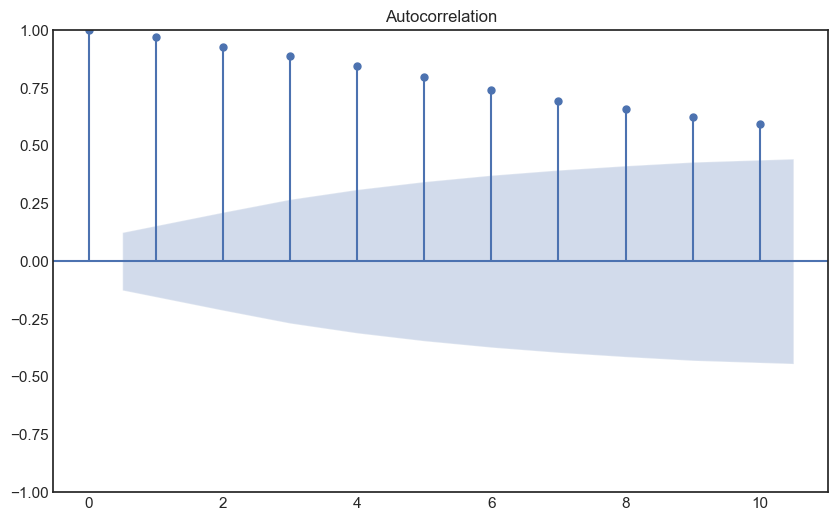

In [20]:
acf = smt.graphics.plot_acf(train_df['FEDFUNDS'], lags=lag_num , alpha=alpha)
acf.show()

Augmented Dickey-Fuller test - 
- If the p-value is less than a chosen significance level (e.g., 0.05), you can reject the null hypothesis of non-stationarity and conclude that the time series is stationary.
- If the p-value is greater than the chosen significance level, there is insufficient evidence to reject the null hypothesis, suggesting that the time series might be non-stationary.

Critical Values
- If the ADF statistic is less (i.e., more negative) than the critical value at a chosen significance level (e.g., 1%), it indicates evidence against the null hypothesis of non-stationarity.
- ADF Stat < critical value - stationary
- ADF Stat > critical value - non stationary

In [21]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_df['FEDFUNDS'])

# Extract and print test results
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.0774070639064046
p-value: 0.25369582947271574
Critical Values:
   1%: -3.458128284586202
   5%: -2.873761835239286
   10%: -2.5732834559706235


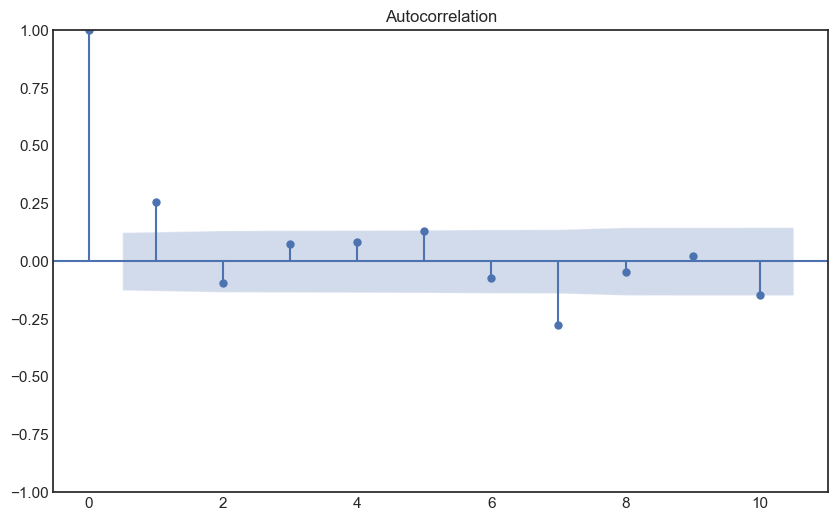

In [22]:
acf = smt.graphics.plot_acf(train_df['FEDFUNDS_diff'], lags=lag_num , alpha=alpha)
acf.show()

In [23]:
# Perform Augmented Dickey-Fuller test
adf_result = adfuller(train_df['FEDFUNDS_diff'])

# Extract and print test results
print('ADF Statistic:', adf_result[0])
print('p-value:', round(adf_result[1],6))
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -6.678766334569835
p-value: 0.0
Critical Values:
   1%: -3.458010773719797
   5%: -2.8737103617125186
   10%: -2.5732559963936206



1. Stationarity: SARIMA assumes that the time series data is stationary or can be made stationary after differencing. Stationarity means that the statistical properties of the series (mean, variance, autocorrelation, etc.) remain constant over time.

- First Difference makes that data stationary
- Seasonal Component (S): Captures the seasonality in the time series data.
- Autoregressive Component (AR): Represents the dependence between an observation and a number of lagged observations.
- Differencing (I): Refers to differencing the time series data to make it stationary.
- Moving Average Component (MA): Captures the dependency between an observation and a residual error from a moving average model.

# tsa.SARIMAX

In [24]:
if True:
    # Define ranges for p, d, q, P, D, Q, S
    p = d = q = range(0, 4)

    # Generate all possible combinations of parameters
    param_combinations = list(product(p, d, q))

    # Fit models and select the best one based on evaluation criteria
    best_aic = np.inf
    best_order = None
    best_seasonal_order = None

    for param in param_combinations:
        print('param: ', param)
        try:
            model = sm.tsa.SARIMAX(y_train, enforce_stationarity=True, exog=X_train_trf , order=param[:3], seasonal_order=(0, 0, 0,0))
            results = model.fit(disp=0)
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = param[:3]
                best_seasonal_order = param[3:]
        except:
            continue

    print(f"Best SARIMAX Order: {best_order}")
    #print(f"Best SARIMAX Seasonal Order: {best_seasonal_order}")

param:  (0, 0, 0)
param:  (0, 0, 1)
param:  (0, 0, 2)
param:  (0, 0, 3)
param:  (0, 1, 0)
param:  (0, 1, 1)
param:  (0, 1, 2)
param:  (0, 1, 3)
param:  (0, 2, 0)
param:  (0, 2, 1)
param:  (0, 2, 2)
param:  (0, 2, 3)
param:  (0, 3, 0)
param:  (0, 3, 1)
param:  (0, 3, 2)
param:  (0, 3, 3)
param:  (1, 0, 0)
param:  (1, 0, 1)
param:  (1, 0, 2)
param:  (1, 0, 3)
param:  (1, 1, 0)
param:  (1, 1, 1)
param:  (1, 1, 2)
param:  (1, 1, 3)
param:  (1, 2, 0)
param:  (1, 2, 1)
param:  (1, 2, 2)
param:  (1, 2, 3)
param:  (1, 3, 0)
param:  (1, 3, 1)
param:  (1, 3, 2)
param:  (1, 3, 3)
param:  (2, 0, 0)
param:  (2, 0, 1)
param:  (2, 0, 2)
param:  (2, 0, 3)
param:  (2, 1, 0)
param:  (2, 1, 1)
param:  (2, 1, 2)
param:  (2, 1, 3)
param:  (2, 2, 0)
param:  (2, 2, 1)
param:  (2, 2, 2)
param:  (2, 2, 3)
param:  (2, 3, 0)
param:  (2, 3, 1)
param:  (2, 3, 2)
param:  (2, 3, 3)
param:  (3, 0, 0)
param:  (3, 0, 1)
param:  (3, 0, 2)
param:  (3, 0, 3)
param:  (3, 1, 0)
param:  (3, 1, 1)
param:  (3, 1, 2)
param:  (3

In [25]:
#model = sm.tsa.SARIMAX(y_train, order=(1,0,0), seasonal_order=(0, 0, 0, 4),enforce_stationarity=True, exog=X_train_trf)
model = sm.tsa.SARIMAX(y_train, order=best_order, seasonal_order=(0, 0, 0, 0) ,enforce_stationarity=True, exog=X_train_trf)
#model = sm.tsa.SARIMAX(y_train, order=(0,1,0), enforce_stationarity=True, exog=X_train_trf)
result_model = model.fit(disp=False)

result_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  246
Model:               SARIMAX(0, 1, 3)   Log Likelihood                -274.498
Date:                Thu, 07 Dec 2023   AIC                            578.996
Time:                        19:04:16   BIC                            631.515
Sample:                    03-31-1962   HQIC                           600.146
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
num__gap_inf                                 0.3812      0.078      4.880      0.000       0.228       0.534
num__gap_ue                                 -0.4327      0.129     -3.345      0.001      -0.686      -0.179
num__FEDFUNDS-1                              4.1365      0.234     17.687      0.000       3.678       4.595
cat__onehotencoder__recession_flag_True     -0.7719      0.167     -4.623      0.000      -1.099      -0.445
cat__onehotencoder__chair_name_Burns         0.0397      0.218      0.182      0.855      -0.388       0.467
cat__onehotencoder__chair_name_Miller        0.3282      0.623      0.527      0.598      -0.893       1.550
cat__onehotencoder__chair_name_Volcker       0.6969      0.361      1.933      0.053      -0.010       1.404
cat__onehotencoder__chair_name_Greenspan    -0.0235      0.292     -0.080      0.936      -0.597       0.550
cat__onehotencoder__chair_name_Bernanke      0.0370      0.479      0.077      0.938      -0.902       0.976
cat__onehotencoder__chair_name_Yellen       -0.3815      1.281     -0.298      0.766      -2.891       2.128
cat__onehotencoder__chair_name_Powell       -0.4751      0.461     -1.030      0.303      -1.379       0.429
ma.L1                                       -0.7282      0.086     -8.499      0.000      -0.896      -0.560
ma.L2                                       -0.4903      0.049    -10.085      0.000      -0.586      -0.395
ma.L3                                        0.2288      0.048      4.748      0.000       0.134       0.323
sigma2                                       0.5386      0.045     12.103      0.000       0.451       0.626
===================================================================================
Ljung-Box (L1) (Q):                   0.25   Jarque-Bera (JB):              1773.71
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               0.09   Skew:                             1.29
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br><br>

**Warnings**

Covariance matrix calculation using the outer product of gradients (complex-step):
- issues with the stability of standard errors.
- Generally, this warning message itself is not an issue unless it's accompanied by other warnings related to convergence or instability.

<br>

Covariance matrix is singular or near-singular, with a high condition number:

- The condition number measures the stability of the covariance matrix. A high condition number (in your case, 3.37e+16) indicates that the matrix is nearly singular or ill-conditioned.
- An ill-conditioned covariance matrix could lead to unstable standard errors for parameter estimates. It implies that the estimation process might be numerically challenging, making the model results less reliable.

<br>

**kurtosi**

Here's a basic interpretation of kurtosis in the context of SARIMA modeling:

<br>

+ Positive Kurtosis:
    - A positive kurtosis indicates that the distribution of residuals has heavier tails and is more peaked (leptokurtic) than a normal distribution.
    - In the context of SARIMA, positive kurtosis might suggest that the residuals have more extreme values (outliers) or a higher likelihood of extreme events than a normal distribution.

<br>

+ Negative Kurtosis:
    - Negative kurtosis indicates that the distribution of residuals has lighter tails and is less peaked (platykurtic) than a normal distribution.
    - In the context of SARIMA, negative kurtosis might suggest that the residuals have fewer extreme values or flatter tails compared to a normal distribution.

<br>

+ Interpretation Caveat:
    - While kurtosis provides information about the shape of the distribution, it's important not to solely rely on kurtosis to draw conclusions about the residuals' behavior. It's essential to consider other measures and conduct thorough diagnostics, such as visual inspections, normality tests, and additional statistical assessments.


In [26]:
train_result = result_model.get_prediction(start=-len(X_train_trf), dynamic=True)
train_pred_SARIM = train_result.summary_frame()

<br>

### Model Diagnostics

The plot_diagnostics() function generates a set of four plots:

- Standardized Residuals Plot: Displays the standardized residuals over time. Look for patterns or large deviations from zero, indicating potential issues with the model's fit or variance. **Check for constant variance, patterns, or outliers.**
- Histogram Plus Estimated Density: Shows the histogram of residuals along with an estimated density plot. It helps in assessing the normality assumption of the residuals. 
- Normal Q-Q Plot: A quantile-quantile (Q-Q) plot compares the distribution of residuals against a theoretical normal distribution. Deviations from the diagonal line suggest non-normality. **Assess the normality assumption of residuals. Deviations from a straight line indicate non-normality.**
- Correlogram: Plots the autocorrelation function (ACF) of the residuals to detect any remaining autocorrelation. **Look for any significant autocorrelation in residuals.**

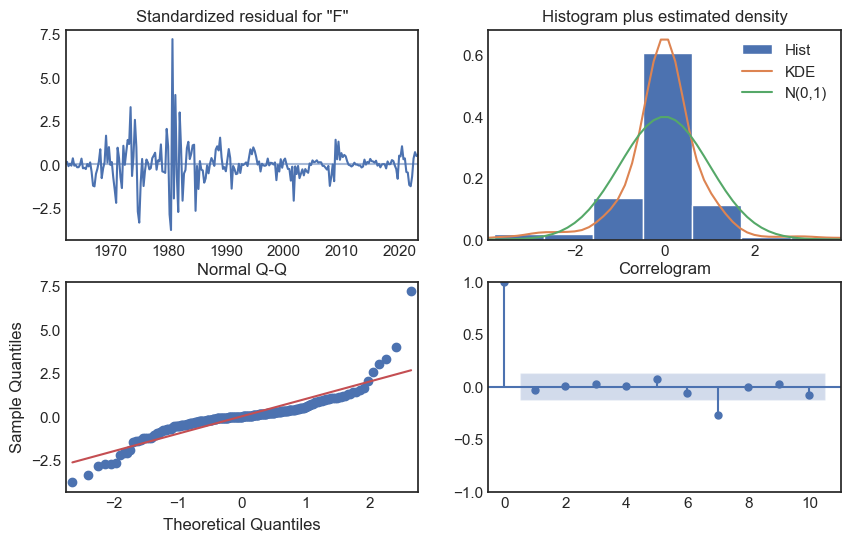

In [27]:
result_model.plot_diagnostics()
plt.show()

In [28]:
table = result_model.summary().tables[1].data
table_df = pd.DataFrame(table[1:], columns=table[0])
table_df.columns = ['feature','coef','std_err','z','p_value','[0.025','0.975]']
table_df = table_df[['feature','coef','p_value']]
table_df['coef'] = pd.to_numeric(table_df['coef'], errors='coerce')
table_df['p_value'] = pd.to_numeric(table_df['p_value'], errors='coerce')
table_df['color'] = np.where(table_df['p_value'] > 0.05, 'lightgray', '#1f77b4')

table_df

,feature,coef,p_value,color
0,num__gap_inf,0.3812,0.0000,#1f77b4
1,num__gap_ue,-0.4327,0.0010,#1f77b4
2,num__FEDFUNDS-1,4.1365,0.0000,#1f77b4
3,cat__onehotencoder__recession_flag_True,-0.7719,0.0000,#1f77b4
4,cat__onehotencoder__chair_name_Burns,0.0397,0.8550,lightgray
5,cat__onehotencoder__chair_name_Miller,0.3282,0.5980,lightgray
6,cat__onehotencoder__chair_name_Volcker,0.6969,0.0530,lightgray
7,cat__onehotencoder__chair_name_Greenspan,-0.0235,0.9360,lightgray
8,cat__onehotencoder__chair_name_Bernanke,0.0370,0.9380,lightgray
9,cat__onehotencoder__chair_name_Yellen,-0.3815,0.7660,lightgray


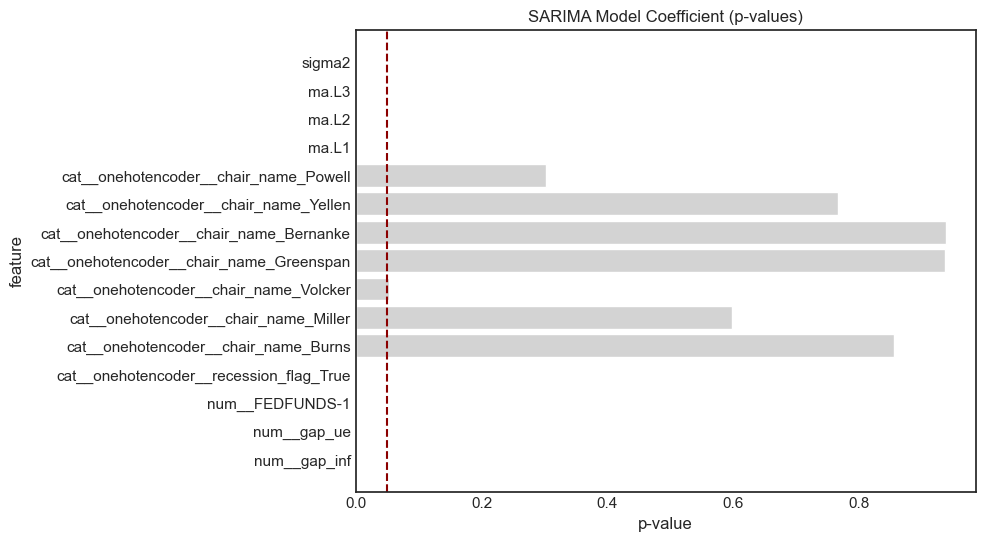

In [29]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(table_df['feature'], table_df['p_value'], color=table_df['color'])

#plt.legend()
plt.xlabel('p-value')
plt.ylabel('feature')
plt.title('SARIMA Model Coefficient (p-values)')
plt.axvline(x=0.05, color='darkred', linestyle='--', label='Threshold: x = 0.05')

plt.grid(False)
plt.show()

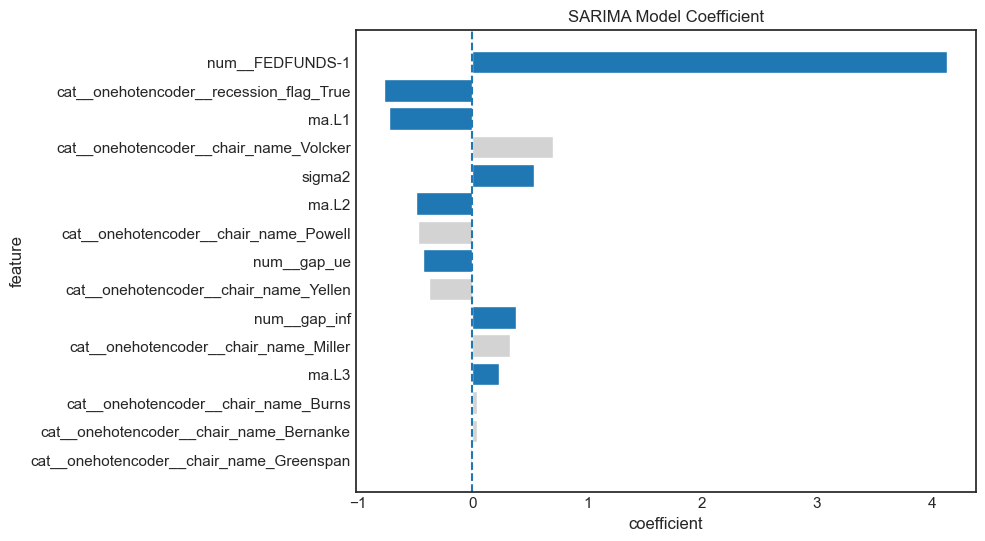

In [30]:
# Plot the MSE values against alphas
t_df = table_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=True ).copy()
#t_df = table_df

plt.figure(figsize=(8, 6))
plt.barh(t_df['feature'], t_df['coef'], color=t_df['color'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('SARIMA Model Coefficient')
plt.axvline(x=0, color='#1f77b4', linestyle='--', label='Threshold: x = 0.05')

plt.grid(False)
plt.show()

### Observations

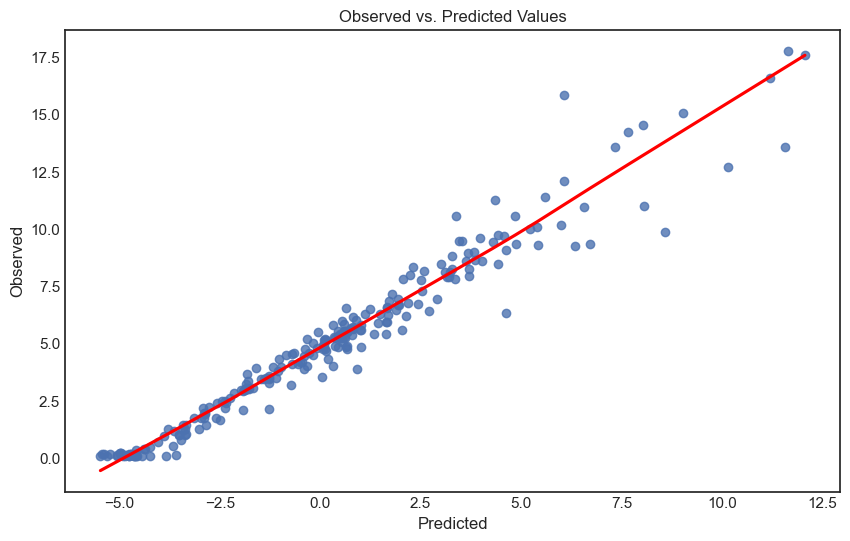

In [31]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_SARIM['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()


### Residuals Analysis

**No Seasonal Patterns** in Residuals: The residuals should not exhibit any seasonality or pattern after fitting the SARIMA model.
Visual Inspection: Observe the plot for any visible patterns in the variance of residuals. Departures from constant variance could indicate heteroskedasticity.
- residual plot and the acf plot

**Independence of Errors:** SARIMA assumes that the residuals (errors) of the model are independent and identically distributed (i.i.d.). Residuals should not exhibit patterns or correlation after fitting the model. 
- Ljung-Box

Normality of Residuals: While not as critical as in some other models, it's beneficial if residuals are normally distributed. Departures from normality might suggest that the model doesn't capture all the information in the data.
- skip this test

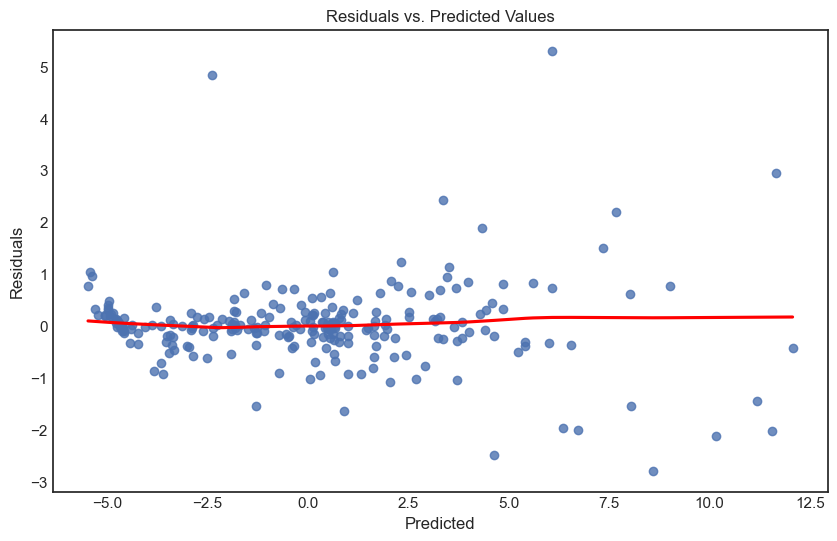

In [32]:
# independence of residuals
residuals = result_model.resid

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_SARIM['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

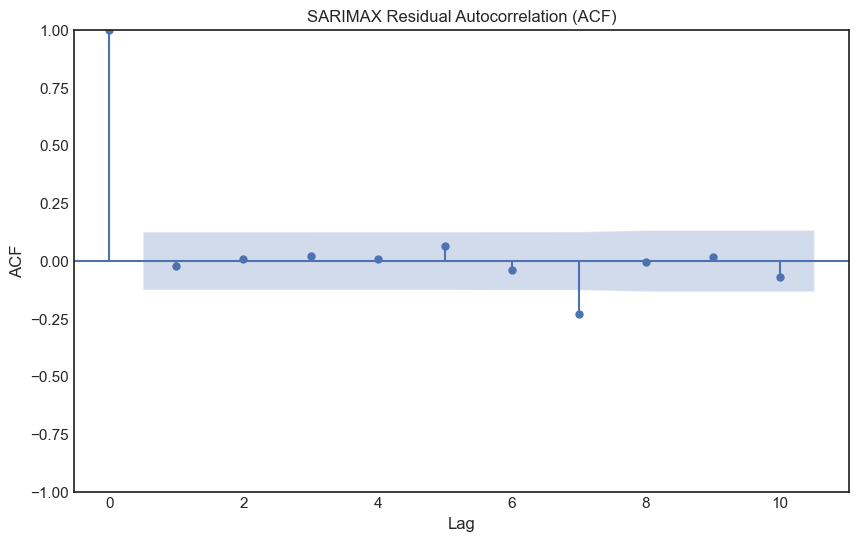

In [33]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('SARIMAX Residual Autocorrelation (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

heteroskedastic - the variance of the residuals is not constant

In [34]:
#lags = min(10, len(residuals)//5)

res = result_model.test_serial_correlation(method='ljungbox', lags=lag_num)
res_df = pd.DataFrame({ 'lag' : range(1, lag_num+1),
                        'test_statistic' : res[:,0][0],
                        'p_value' : res[:,1][0]})
res_df

,lag,test_statistic,p_value
0,1,0.2469,0.6193
1,2,0.2473,0.8837
2,3,0.4215,0.9358
3,4,0.4310,0.9799
4,5,1.9061,0.8620
5,6,2.8048,0.8329
6,7,21.3579,0.0033
7,8,21.3615,0.0062
8,9,21.4984,0.0106
9,10,23.0462,0.0106


**Heteroskedasticity (changing variance)**

- If we used a heteroskedastic robust estimate of the covariance matrix, maybe we would correct for that weird result.
- Constant Variance: The variance of the residuals should remain constant across time. Heteroskedasticity (changing variance) in residuals can affect the reliability of model results.
- p_val < 0.05 suggest heteroskedasticity

In [35]:
test_stat, p_val = result_model.test_heteroskedasticity(method = 'breakvar')[0]
print('--- heteroskedasticity -- ')
print('test_stat: ',test_stat, '  ' , 'p_val: ', p_val)

--- heteroskedasticity -- 
test_stat:  0.09318295867372572    p_val:  1.8923906808363261e-22


The het_arch() function performs the Ljung-Box test for the squared residuals to test for the presence of autocorrelation in squared residuals, indicating heteroskedasticity. A low p-value (< 0.05) suggests evidence against the null hypothesis of no heteroskedasticity, indicating the presence of heteroskedasticity in the time series residuals.

ARCH Test: A lower p-value (< 0.05) suggests evidence against constant variance (presence of heteroskedasticity). 

A higher p-value indicates that there is no strong evidence against constant variance.

In [36]:
res = het_arch(residuals)
print('--- heteroskedasticity -- ')
print('Ljung-Box Test Results: ',res[0], '  ' , 'p_val: ', round(res[1],10))

--- heteroskedasticity -- 
Ljung-Box Test Results:  49.05692661670845    p_val:  3.977e-07


In [37]:
print('aic', result_model.aic)

aic 578.9962379013191


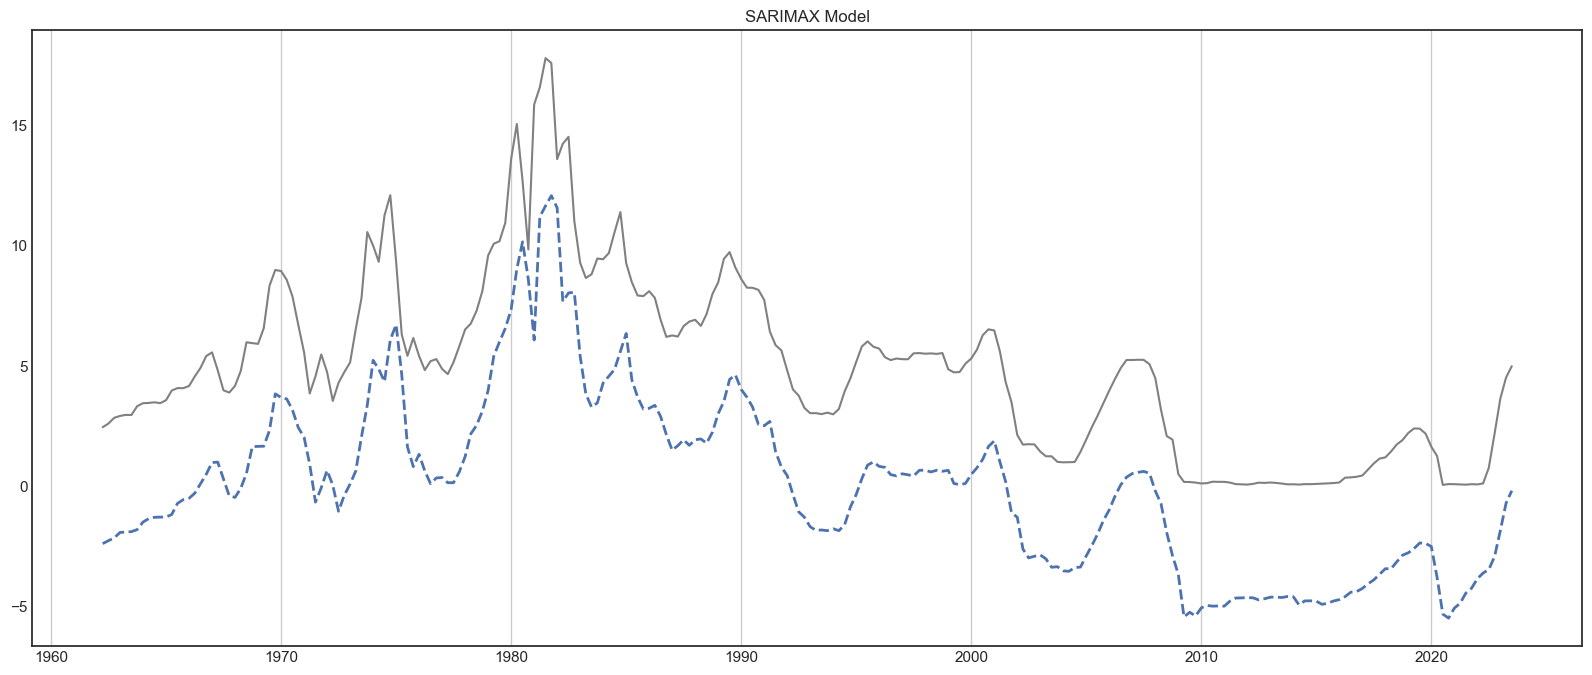

In [38]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_SARIM.index, train_pred_SARIM['mean'], linestyle='--', linewidth=2)
#ax.plot(test_pred_SARIM.index, test_pred_SARIM['mean'], linestyle='--', linewidth=2)
#ax.fill_between(test_pred_SARIM.index, predict_ci['lower'], predict_ci['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [39]:
model_stats_df = model_results('SARIMAX_train',y_train, train_pred_SARIM['mean'], result_model.aic, model_stats_df )
#model_stats_df = model_results('SARIMAX_test', y_test, test_pred_SARIM['mean'], 0, model_stats_df )

# auto arima

In [40]:
# Initiate and Fit Model
arima_model = pm.auto_arima(y = y_train, 
                            X = X_train_trf,
                            start_d = 1,
                            #d = 1,
                            test='adf', 
                            seasonal=False, 
                            error_action='ignore',  
                            suppress_warnings=False,
                            stepwise=True, trace=True)



Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=608.406, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1008.038, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=626.882, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=842.054, Time=0.11 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=599.581, Time=0.19 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=785.995, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=612.662, Time=0.17 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=603.330, Time=0.22 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=744.873, Time=0.21 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=617.726, Time=0.19 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=608.659, Time=0.23 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=610.933, Time=0.22 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 2.182 seconds


In [41]:
type(arima_model)

pmdarima.arima.arima.ARIMA

In [42]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  246
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -284.791
Date:                Thu, 07 Dec 2023   AIC                            599.581
Time:                        19:04:19   BIC                            652.161
Sample:                    03-31-1962   HQIC                           620.753
                         - 06-30-2023                                         
Covariance Type:                  opg                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
num__gap_inf                                 0.4357      0.095      4.597      0.000       0.250       0.621
num__gap_ue                                 -0.6256      0.119     -5.275      0.000      -0.858      -0.393
num__FEDFUNDS-1                              3.2551      0.307     10.596      0.000       2.653       3.857
cat__onehotencoder__recession_flag_True     -0.3517      0.204     -1.721      0.085      -0.752       0.049
cat__onehotencoder__chair_name_Burns         0.0643      0.599      0.107      0.914      -1.109       1.237
cat__onehotencoder__chair_name_Miller        0.7730      0.959      0.806      0.420      -1.106       2.652
cat__onehotencoder__chair_name_Volcker       1.9479      0.925      2.106      0.035       0.135       3.761
cat__onehotencoder__chair_name_Greenspan     1.3525      1.552      0.871      0.383      -1.689       4.394
cat__onehotencoder__chair_name_Bernanke      1.6240      2.087      0.778      0.437      -2.467       5.715
cat__onehotencoder__chair_name_Yellen        1.0247      2.702      0.379      0.704      -4.271       6.320
cat__onehotencoder__chair_name_Powell        1.0119      2.983      0.339      0.734      -4.835       6.859
ar.L1                                        0.9987      0.002    457.560      0.000       0.994       1.003
ma.L1                                       -0.4730      0.083     -5.692      0.000      -0.636      -0.310
ma.L2                                       -0.3796      0.045     -8.395      0.000      -0.468      -0.291
sigma2                                       0.5969      0.033     18.124      0.000       0.532       0.661
===================================================================================
Ljung-Box (L1) (Q):                   1.05   Jarque-Bera (JB):              3043.82
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             1.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<br>

### Model Diagnostics
Here's a brief interpretation of the AIC in the context of auto_arima:

- Lower AIC value: A lower AIC indicates a better trade-off between model goodness of fit and complexity. Among competing ARIMA models, the one with the lowest AIC is generally preferred.
- Comparing AIC values: When comparing models fitted by auto_arima, select the model with the lowest AIC value as it suggests the best balance between explaining the variance in the data and model complexity.
- AIC as a relative measure: The AIC doesn't provide an absolute measure of goodness of fit, but rather a relative measure among candidate models. You can compare AIC values across different models to identify the one that best fits the data while keeping the model as simple as possible.


According to the model summary, the model meets the condition of independence in the residuals (no correlation) because the p-value of the Ljung-Box test (Prob(Q)) is greater than 0.05, so we cannot reject the null hypothesis of independence, but we cannot say that the residual distribution is homoscedastic (constant variance) because the p-value of the Heteroskedasticity test (Prob(H)) is smaller than 0.05.

This time, the p-value of the Heteroskedasticity test is greater than 0.05, indicating that the model explains better the variance in the data. This model outperforms the previous one in terms of dependability. This demonstrates that ARIMA is superior for short-term forecasting.

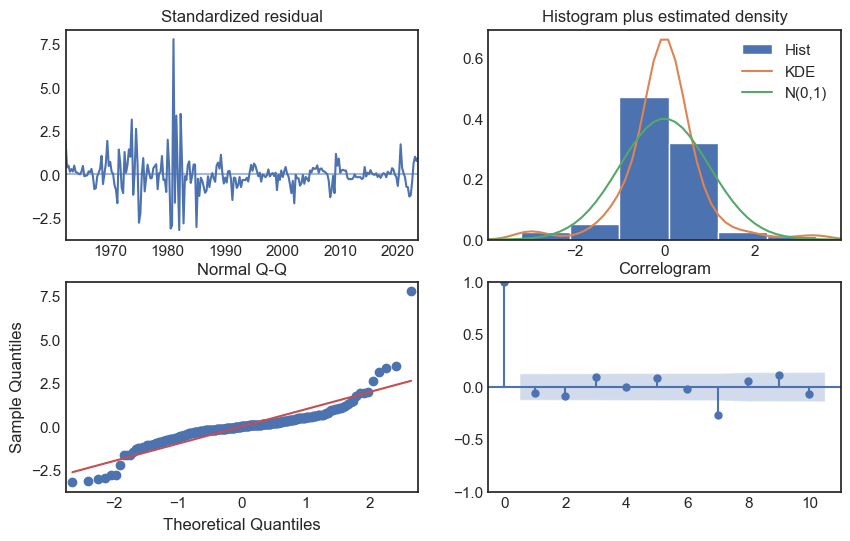

In [43]:
arima_model.plot_diagnostics()
plt.show()

We can see from the model plots that the Correlogram does not show any significant correlation in the residuals. The standardized residual plot depicts variance change, while the normal Q-Q plot demonstrates that the residuals do not follow a normal distribution (but this is not a strict requirement to validate the model).

In [44]:
predict, confint = arima_model.predict_in_sample(X=X_train_trf, return_conf_int=True)
train_pred_pmdarima = pd.DataFrame(predict)
train_pred_pmdarima.columns = ['mean']
train_pred_pmdarima['lower'] = confint[:,0]
train_pred_pmdarima['upper'] = confint[:,1]
train_pred_pmdarima.shape

(246, 3)

result_model.summary().tables[1]

arima_model.summary().tables[1]

In [45]:
table = arima_model.summary().tables[1].data
table_df = pd.DataFrame(table[1:], columns=table[0])
table_df.columns = ['feature','coef','std_err','z','p_value','[0.025','0.975]']
table_df = table_df[['feature','coef','p_value']]
table_df['coef'] = pd.to_numeric(table_df['coef'], errors='coerce')
table_df['p_value'] = pd.to_numeric(table_df['p_value'], errors='coerce')
table_df['color'] = np.where(table_df['p_value'] > 0.05, 'lightgray', '#1f77b4')

table_df

,feature,coef,p_value,color
0,num__gap_inf,0.4357,0.0000,#1f77b4
1,num__gap_ue,-0.6256,0.0000,#1f77b4
2,num__FEDFUNDS-1,3.2551,0.0000,#1f77b4
3,cat__onehotencoder__recession_flag_True,-0.3517,0.0850,lightgray
4,cat__onehotencoder__chair_name_Burns,0.0643,0.9140,lightgray
5,cat__onehotencoder__chair_name_Miller,0.7730,0.4200,lightgray
6,cat__onehotencoder__chair_name_Volcker,1.9479,0.0350,#1f77b4
7,cat__onehotencoder__chair_name_Greenspan,1.3525,0.3830,lightgray
8,cat__onehotencoder__chair_name_Bernanke,1.6240,0.4370,lightgray
9,cat__onehotencoder__chair_name_Yellen,1.0247,0.7040,lightgray


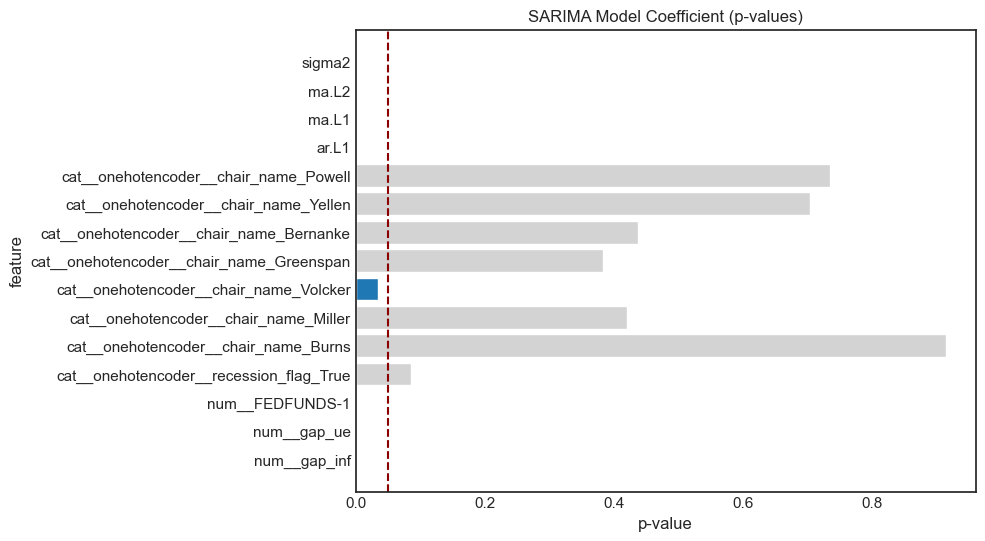

In [46]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(table_df['feature'], table_df['p_value'], color=table_df['color'])

#plt.legend()
plt.xlabel('p-value')
plt.ylabel('feature')
plt.title('SARIMA Model Coefficient (p-values)')
plt.axvline(x=0.05, color='darkred', linestyle='--', label='Threshold: x = 0.05')

plt.grid(False)
plt.show()

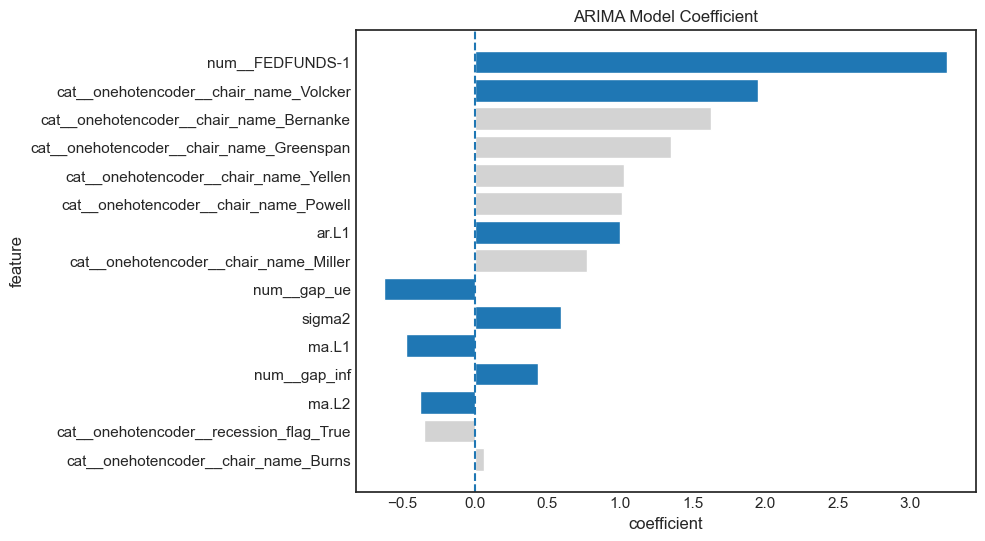

In [47]:
# Plot the MSE values against alphas
t_df = table_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=True ).copy()
#t_df = table_df

plt.figure(figsize=(8, 6))
plt.barh(t_df['feature'], t_df['coef'], color=t_df['color'])

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('ARIMA Model Coefficient')
plt.axvline(x=0, color='#1f77b4', linestyle='--', label='Base Line: x = 0')

plt.grid(False)
plt.show()

### Observations Analysis

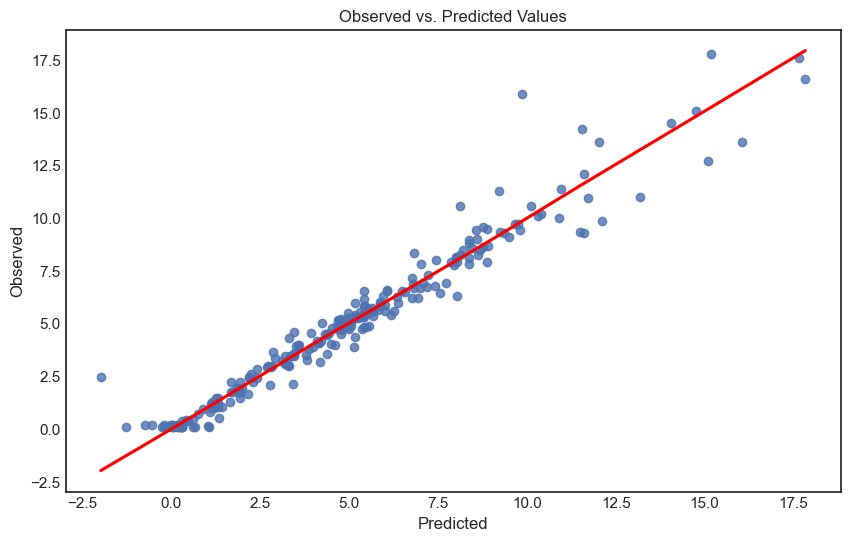

In [48]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_pmdarima['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### Residual Analysis

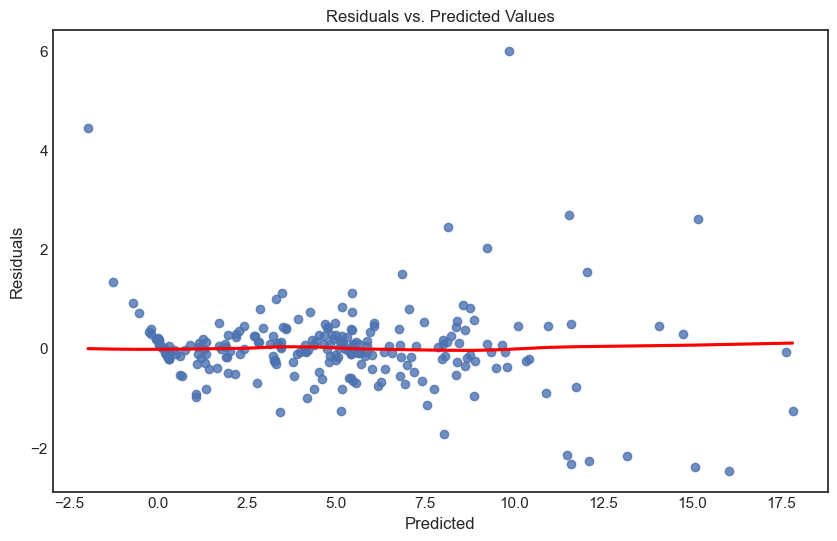

In [49]:
# independence of residuals
residuals = arima_model.resid()

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_pmdarima['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

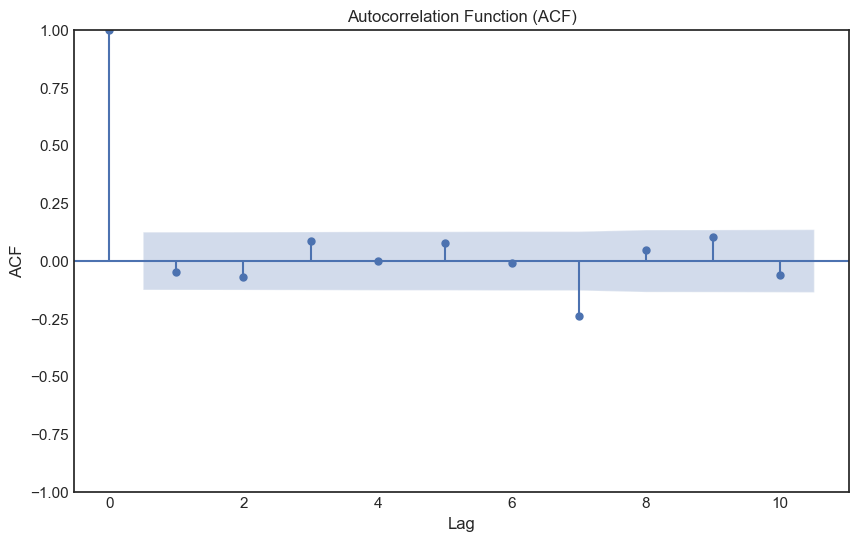

In [50]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

In [51]:
lags = min(10, len(residuals)//5)  # Adjust the number of lags as needed
res_df = acorr_ljungbox(residuals, lags=lags)
res_df['lag'] = res_df.index
res_df = res_df.reindex(columns=['lag','lb_stat','lb_pvalue'])

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
res_df

Ljung-Box Test Results:


,lag,lb_stat,lb_pvalue
1,1,0.6283,0.4280
2,2,1.8435,0.3978
3,3,3.6630,0.3002
4,4,3.6641,0.4534
5,5,5.2137,0.3904
6,6,5.2476,0.5125
7,7,19.7349,0.0062
8,8,20.3009,0.0093
9,9,22.9316,0.0064
10,10,23.9051,0.0079


The het_arch() function performs the Ljung-Box test for the squared residuals to test for the presence of autocorrelation in squared residuals, indicating heteroskedasticity. A low p-value (< 0.05) suggests evidence against the null hypothesis of no heteroskedasticity, indicating the presence of heteroskedasticity in the time series residuals.

ARCH Test: A lower p-value (< 0.05) suggests evidence against constant variance (presence of heteroskedasticity). 

A higher p-value indicates that there is no strong evidence against constant variance.

In [52]:
res = het_arch(residuals)
print('--- heteroskedasticity -- ')
print('Ljung-Box Test Results: ',res[0], '  ' , 'p_val: ', round(res[1],10))

--- heteroskedasticity -- 
Ljung-Box Test Results:  40.155032568120625    p_val:  1.5912e-05


In [53]:
print('aic', result_model.aic)

aic 578.9962379013191


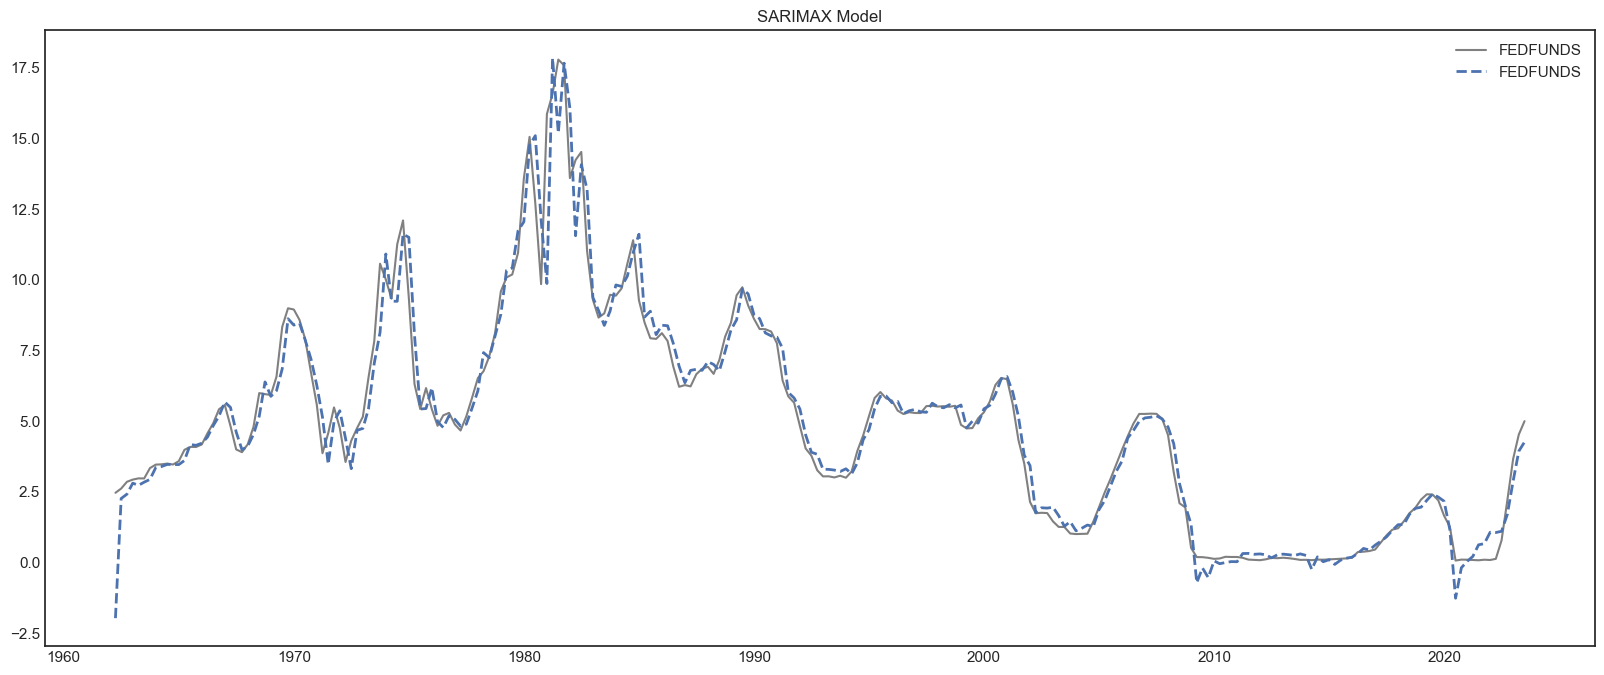

In [54]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_pmdarima.index, train_pred_pmdarima['mean'], linestyle='--', linewidth=2)
#ax.plot(test_pred_pmdarima.index, test_pred_pmdarima['mean'], linestyle='--', linewidth=2)
#ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.legend(["FEDFUNDS","FEDFUNDS","train_pred_pmdarima","test_pred_pmdarima"])
ax.set(title='Federal Funds Effective Rate (Actual vs Predicted)');

ax.set(title='SARIMAX Model');

# ETSModel

In [55]:
#ets_model = ETSModel(train_df['FEDFUNDS_CPIAUCNS_PC1'], error='add', trend='add', seasonal='add', seasonal_periods=4)
#ets_model = ETSModel(train_df['FEDFUNDS'])
ets_model = ETSModel(y_train)

fit_ets_model = ets_model.fit(disp=False)
fit_ets_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:               FEDFUNDS   No. Observations:                  246
Model:                       ETS(ANN)   Log Likelihood                -318.953
Date:                Thu, 07 Dec 2023   AIC                            643.906
Time:                        19:04:20   BIC                            654.422
Sample:                    03-31-1962   HQIC                           648.140
                         - 06-30-2023   Scale                            0.783
Covariance Type:               approx                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
smoothing_level     0.9999      0.077     12.928      0.000       0.848       1.151
initial_level       2.4567      0.885      2.776      0.005       0.722       4.191
===================================================================================
Ljung-Box (Q):                       18.47   Jarque-Bera (JB):              1364.39
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.11   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

In [56]:
train_pred_ets = fit_ets_model.predict(start=y_train.index[0], end=y_train.index[-1])
train_pred_ets = pd.DataFrame({'mean' : train_pred_ets})
train_pred_ets.index.name = 'DATE'
train_pred_ets.shape

(246, 1)

### Observations Analysis

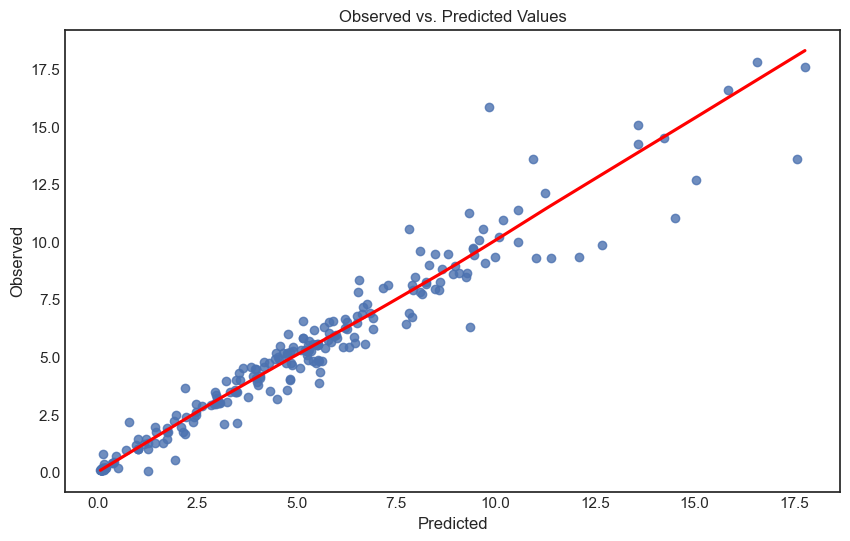

In [57]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_ets['mean'], y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### Residual Analysis

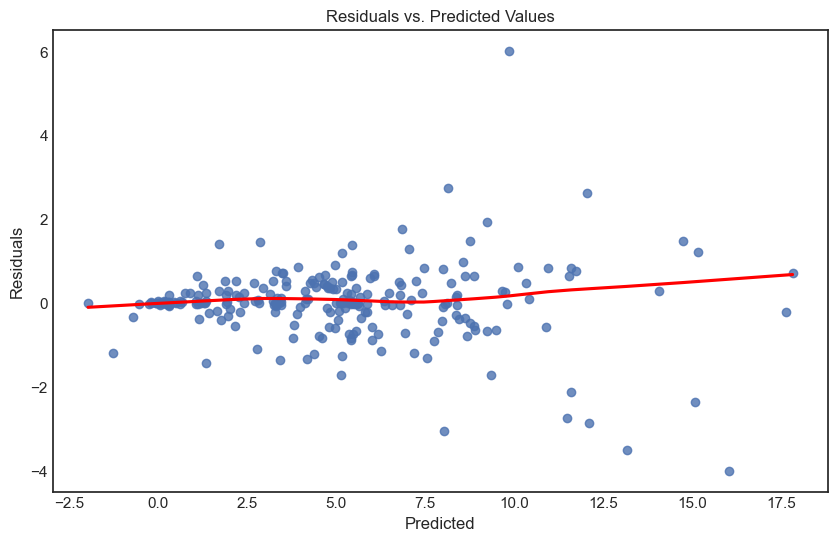

In [58]:
# independence of residuals
residuals = fit_ets_model.resid

fig, ax = plt.subplots(1)
sns.regplot(x=train_pred_pmdarima['mean'], y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

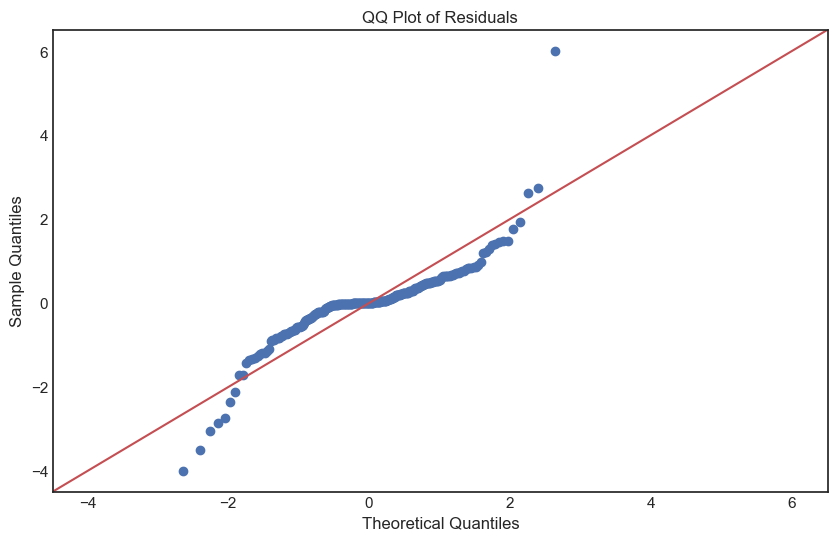

In [59]:
# Create a QQ plot for the residuals
sm.qqplot(residuals, line='45')  # 'line='45'' adds a 45-degree line for reference
plt.title('QQ Plot of Residuals')
plt.show()

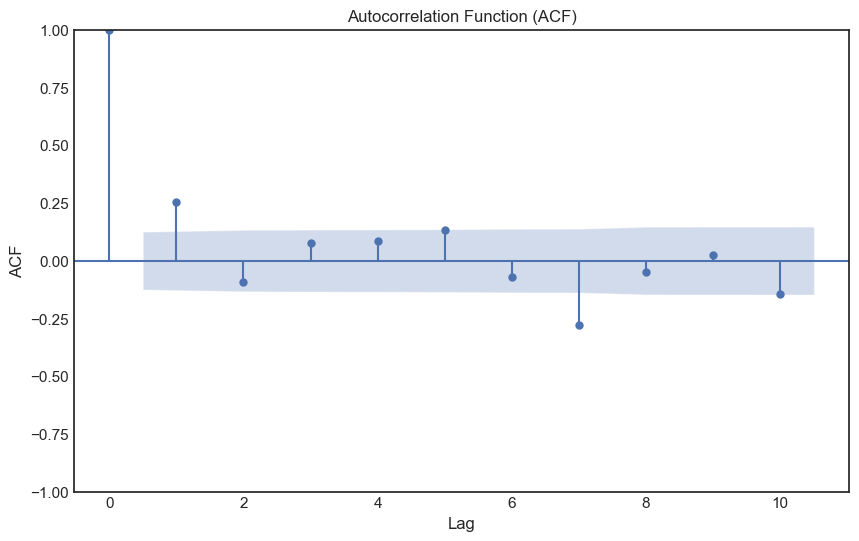

In [60]:
acf = smt.graphics.plot_acf(residuals, lags=lag_num , alpha=alpha)
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.title('Autocorrelation Function (ACF)')
acf.show()

The **Ljung-Box** test is used to assess whether autocorrelation exists in a time series at different lag intervals. It examines whether there is any significant correlation between the residuals of a model at various lags.

- H0: The residuals are independently distributed. (< 0.05 evidence of autocorrelation)
- HA: The residuals are not independently distributed; they exhibit serial correlation (> 0.05 fail to reject null hypothesis)

Autocorrelation in residuals implies that the model has not captured all the information in the time series data.
Ideally, residuals should not display significant autocorrelation, indicating that the model has successfully accounted for the temporal dependencies in the data.

In [61]:
lags = min(10, len(residuals)//5)  # Adjust the number of lags as needed
res_df = acorr_ljungbox(residuals, lags=lags)

# Print Ljung-Box test results
print("Ljung-Box Test Results:")
res_df

Ljung-Box Test Results:


,lb_stat,lb_pvalue
1,16.2369,0.0001
2,18.4674,0.0001
3,19.9168,0.0002
4,21.7345,0.0002
5,26.0670,0.0001
6,27.3953,0.0001
7,46.9599,0.0000
8,47.5630,0.0000
9,47.7118,0.0000
10,53.1082,0.0000


train_pred_ets = fit_ets_model.forecast(steps=y_train.shape[0]) 
train_pred_ets = pd.DataFrame({'mean' : train_pred_ets})
train_pred_ets.index.name = 'DATE'
train_pred_ets.shape

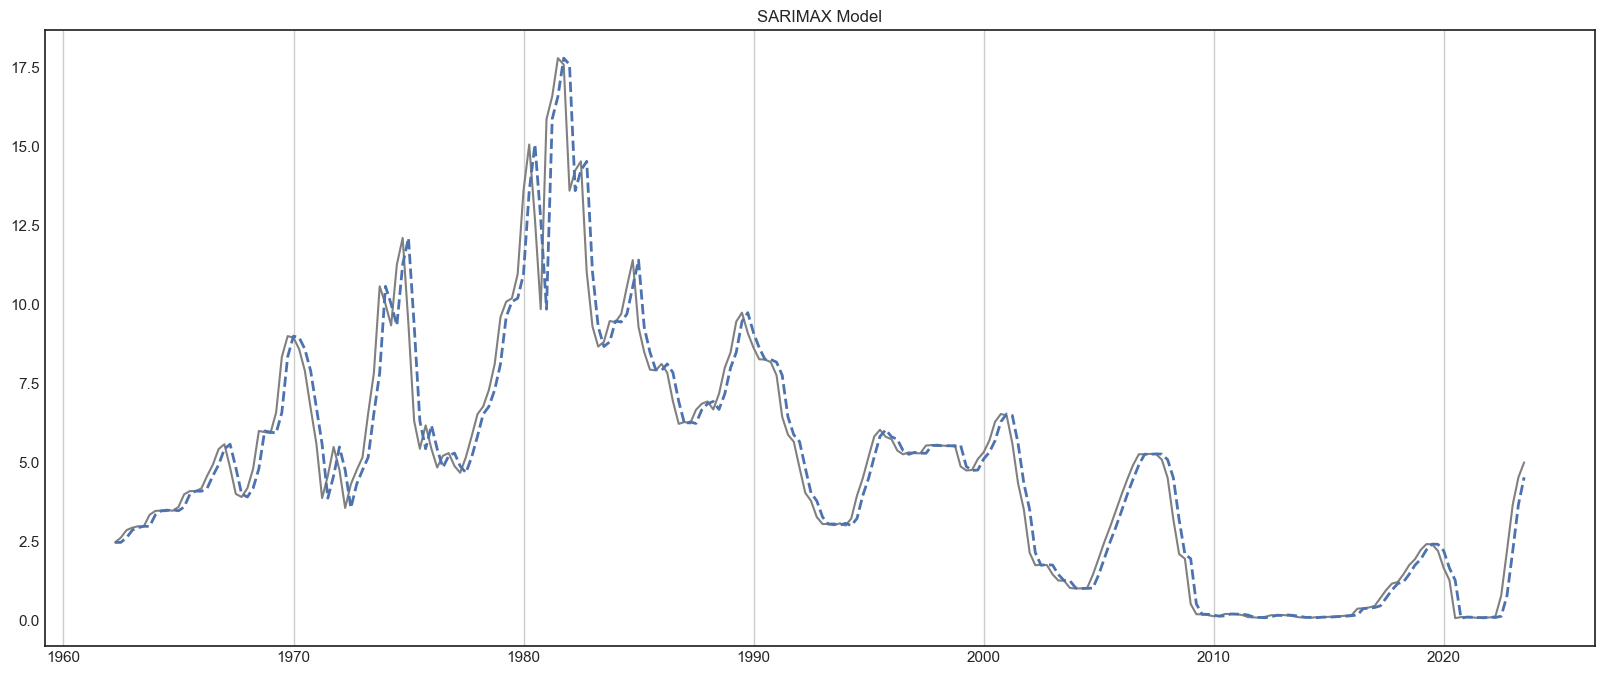

In [62]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid()

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'gray')
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'gray')
ax.plot(train_pred_ets.index, train_pred_ets['mean'], linestyle='--', linewidth=2)
#ax.plot(test_pred_ets.index, test_pred_ets['mean'], linestyle='--', linewidth=2)
#ax.fill_between(test_pred_pmdarima.index, test_pred_pmdarima['lower'], test_pred_pmdarima['upper'], alpha=0.15)

ax.set(title='SARIMAX Model');

In [63]:
model_stats_df = model_results('ets_train',y_train, train_pred_ets['mean'], fit_ets_model.aic , model_stats_df )
#model_stats_df = model_results('ets_test', y_test, test_pred_ets['mean'], 0 , model_stats_df )

# Results


- A smaller MSE indicates better performance. Lower values of MSE suggest that, on average, the model's predictions have smaller deviations from the actual values, indicating higher accuracy.
- A smaller RMSE indicates better performance. Lower values of RMSE imply that, on average, the model's predictions are closer to the actual values, suggesting higher accuracy.
- A smaller MAPE indicates better performance. Lower values of MAPE imply that, on average, the model's predictions have a smaller percentage deviation from the actual values, indicating higher accuracy.
- A smaller MAE indicates better performance. Lower values of MAE indicate that, on average, the model's predictions are closer to the actual values, implying higher accuracy.
- Lower AIC value: A lower AIC indicates a better trade-off between model goodness of fit and complexity. Among competing ARIMA models, the one with the lowest AIC is generally preferred.

In [64]:
model_stats_df

,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,31.7498,5.6347,9.9857,4.9215,0
1,ffef_tr2_train,0.9629,0.9813,0.8930,0.6269,0
2,SARIMAX_train,23.6237,4.8604,7.8459,4.7991,578.9962
3,ets_train,0.7829,0.8848,0.2210,0.5096,643.9061


long_df: (2706, 3)


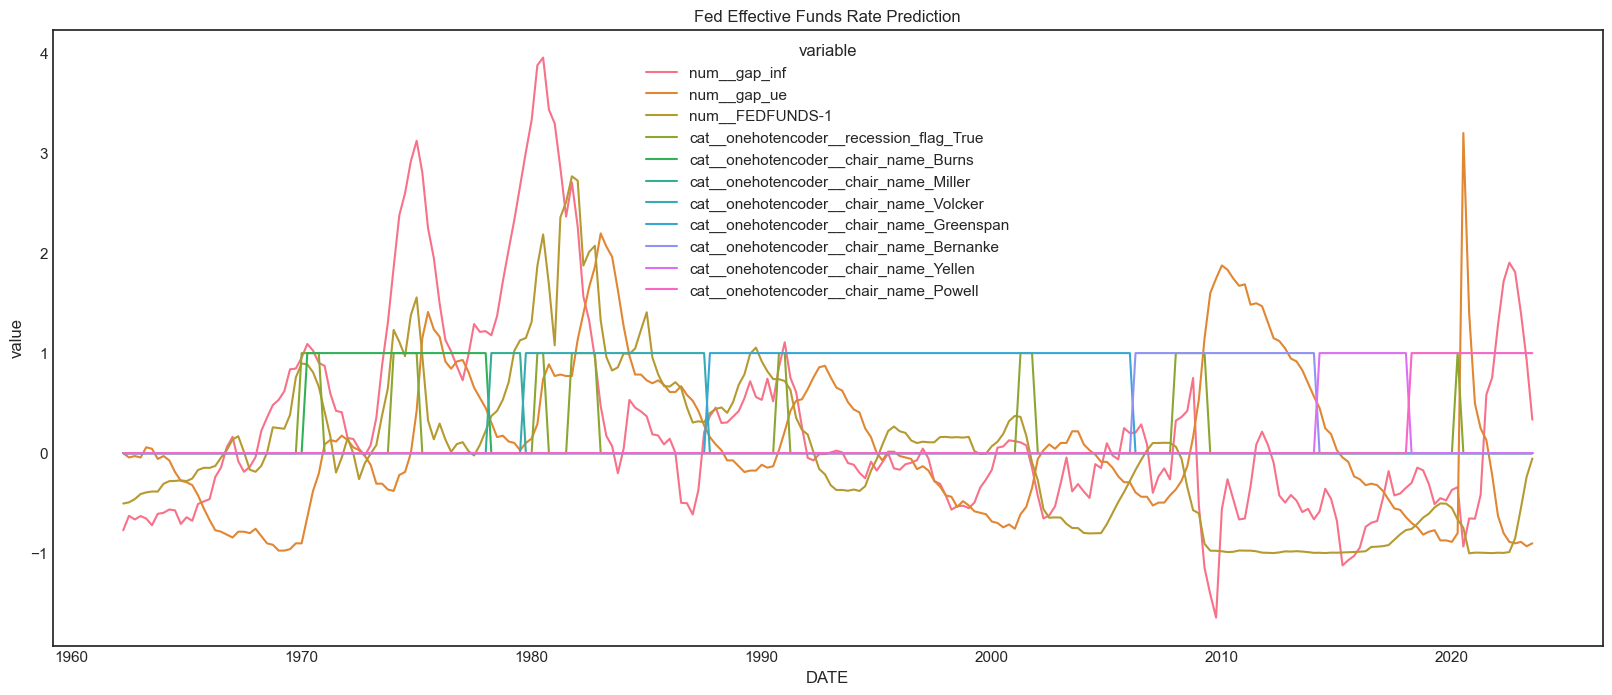

In [65]:
# Long 
long_df = X_train_trf.copy()
long_df.reset_index(inplace=True)
long_df = long_df.melt(id_vars=['DATE'])
#long_df = long_df[['DATE','FEDFUNDS','ffef_tr','gap_inf','gap_gdp']].melt(id_vars=['DATE'])
print('long_df:', long_df.shape)

# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
#ax.plot(long_df['observation_date'], long_df['value'], color='variable')
sns.lineplot(x = 'DATE', y = 'value', data=long_df, hue='variable')

ax.set(title='Fed Effective Funds Rate Prediction');

# Lasso

In [66]:
pipe_lasso = Pipeline(
    steps = [ ('preprocessor',preprocessor), ('model',linear_model.LassoCV(cv=5, 
                                                                           #alphas=[0.001, 0.01,0.05, 0.1, 0.5],
                                                                           random_state=rand_int, 
                                                                           max_iter=10000))]
)

param_lasso = {
    #'model__alpha': [0.01, 0.05, 0.1, 0.5],
    'model__verbose': [0],
}


cv = RandomizedSearchCV(estimator = pipe_lasso, 
                        param_distributions = param_lasso,
                        random_state=rand_int, 
                        scoring="neg_root_mean_squared_error")

cv.fit(X_train, y_train)
cv_results = cv.cv_results_['mean_test_score']
print('Lasso', ') Best Accuracy Score:' , cv.best_score_ , 'Parameters: {}' , cv.best_params_)

Lasso ) Best Accuracy Score: -0.7542077102510307 Parameters: {} {'model__verbose': 0}


In [67]:
lasso_best = linear_model.Lasso(alpha=cv.best_estimator_.named_steps.model.alpha_)

lasso_best.fit(X_train_trf, y_train)

train_pred_lasso = lasso_best.predict(X_train_trf)

In [68]:
feature_df = pd.DataFrame(lasso_best.coef_, t_fit.get_feature_names_out())
feature_df.columns = ['coef']
feature_df.sort_values(by=['coef'], key=pd.Series.abs , ascending=True , inplace=True)
feature_df

,coef
cat__onehotencoder__chair_name_Burns,-0.0000
cat__onehotencoder__chair_name_Miller,0.0000
cat__onehotencoder__chair_name_Greenspan,-0.0000
cat__onehotencoder__chair_name_Bernanke,-0.0000
cat__onehotencoder__chair_name_Yellen,-0.0000
cat__onehotencoder__chair_name_Powell,-0.0000
cat__onehotencoder__chair_name_Volcker,0.1696
num__gap_ue,-0.2361
num__gap_inf,0.3024
cat__onehotencoder__recession_flag_True,-0.5773


In [69]:
feature_df.index

Index(['cat__onehotencoder__chair_name_Burns',
       'cat__onehotencoder__chair_name_Miller',
       'cat__onehotencoder__chair_name_Greenspan',
       'cat__onehotencoder__chair_name_Bernanke',
       'cat__onehotencoder__chair_name_Yellen',
       'cat__onehotencoder__chair_name_Powell',
       'cat__onehotencoder__chair_name_Volcker', 'num__gap_ue', 'num__gap_inf',
       'cat__onehotencoder__recession_flag_True', 'num__FEDFUNDS-1'],
      dtype='object')

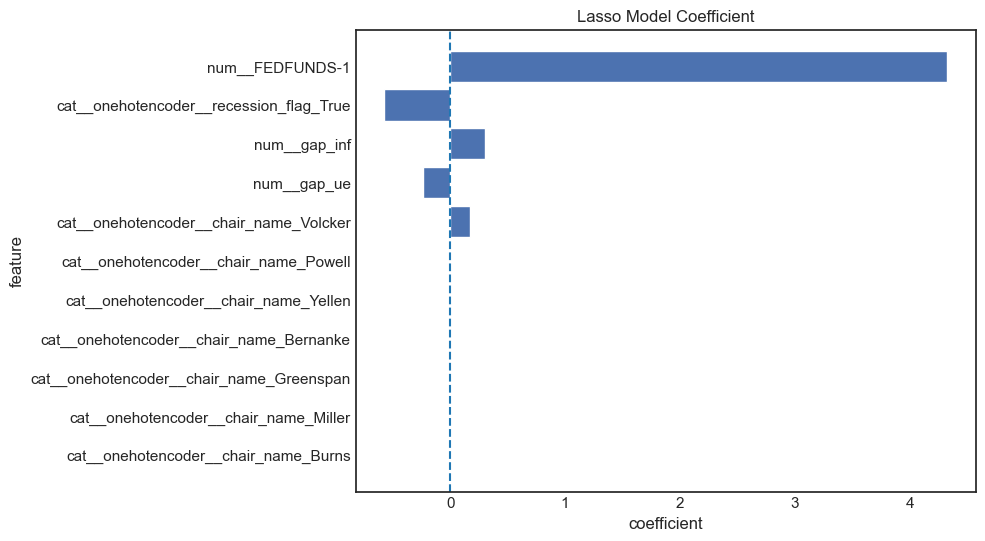

In [70]:
# Plot the MSE values against alphas
plt.figure(figsize=(8, 6))
plt.barh(feature_df.index, feature_df['coef'])
plt.axvline(x=0, color='#1f77b4', linestyle='--', label='Base Line: x = 0')

#plt.legend()
plt.xlabel('coefficient')
plt.ylabel('feature')
plt.title('Lasso Model Coefficient')
plt.grid(False)
plt.show()

### linearity assumption Interpretation:
Ideally, the scatter plot should show a strong linear relationship along the diagonal line (y = x). This indicates that the model's predictions are close to the actual values.
A scattered or disperse pattern away from the diagonal line might indicate areas where the model performs poorly, potentially highlighting non-linearity or other issues in the model.

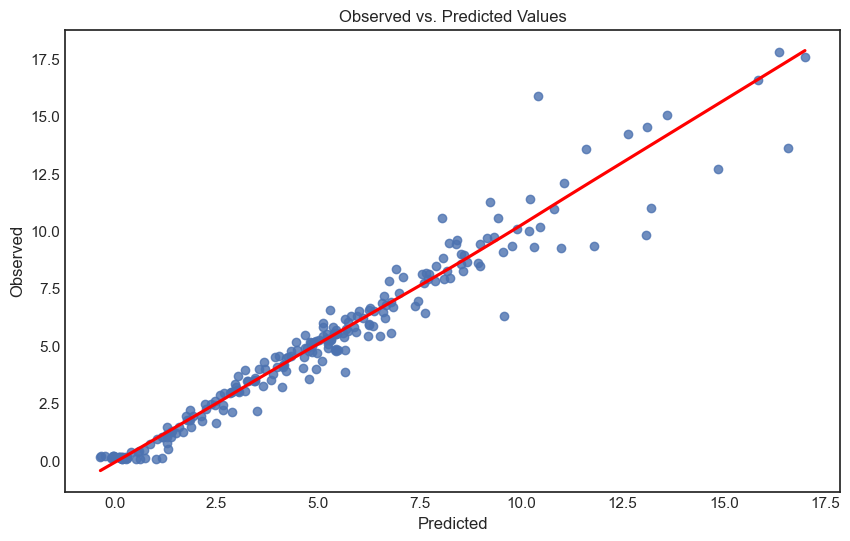

In [71]:
fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=y_train, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Observed vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Observed')

plt.show()

### independence of residuals Iterpretation:
In the scatter plot(s), check for a consistent spread of residuals around zero. If the spread of residuals widens or narrows systematically as predicted values or predictor values change, it suggests heteroscedasticity, violating the assumption of homoscedasticity.

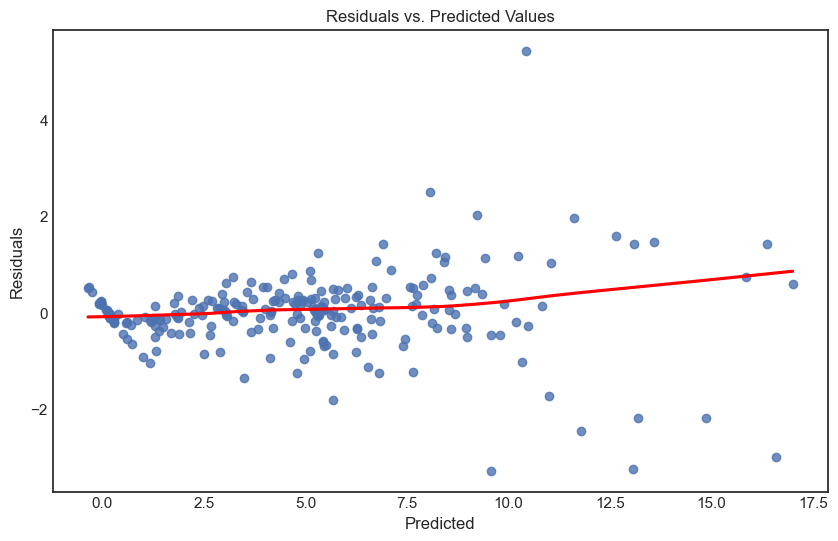

In [72]:
# independence of residuals

residuals = y_train - train_pred_lasso

fig, ax = plt.subplots(1)

sns.regplot(x=train_pred_lasso, y=residuals, lowess=True, ax=ax, line_kws={'color': 'red'})
ax.set_title('Residuals vs. Predicted Values', fontsize=12)
ax.set(xlabel='Predicted', ylabel='Residuals')

plt.show()

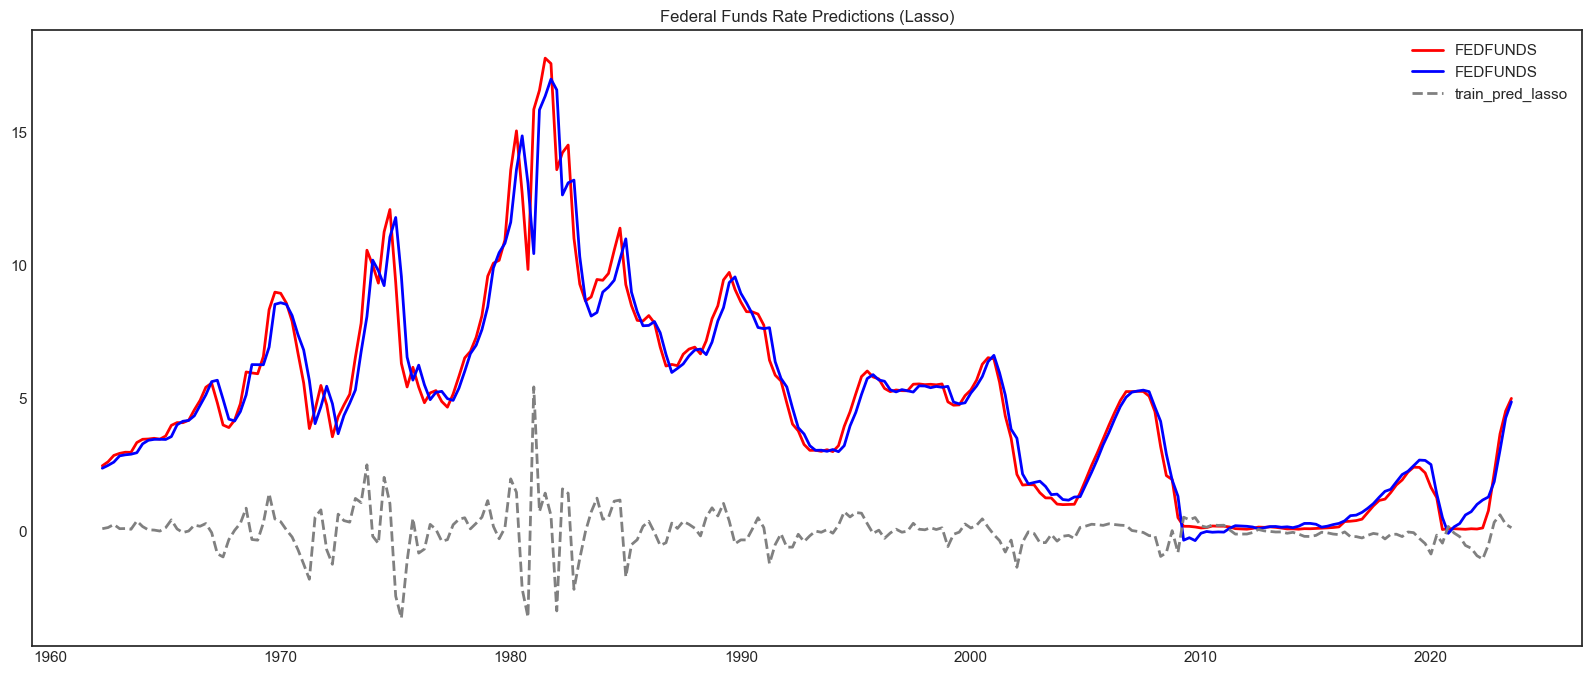

In [73]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(y_train.index, y_train, 'lightgray', color='red',linewidth=2)
ax.plot(y_train.index, train_pred_lasso, 'lightgray', color='blue',linewidth=2)
ax.plot(y_train.index, residuals, 'lightgray', linestyle="--",color='gray',linewidth=2)


ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

In [74]:
# values for durbin watson test is between 0 and 4 the value close to 2 is accurate
# Durbin-Watson Test: Provides a measure (statistic) that ranges from 0 to 4. A value around 2 
# suggests no autocorrelation. Values closer to 0 indicate positive autocorrelation, 
# while values near 4 suggest negative autocorrelation.

durbin_watson_stat = durbin_watson(residuals)
print("Durbin-Watson statistic:", durbin_watson_stat)

Durbin-Watson statistic: 1.6632911204356446


In [75]:
# Perform Shapiro-Wilk test for normality
shapiro_test = shapiro(residuals)

# p-value < 0.05 - reject the null hypothesis residuals are not normally distrivuted
# Display the Shapiro-Wilk test statistic and p-value
print("Shapiro-Wilk Test Statistic:", shapiro_test.statistic)
print("Shapiro-Wilk p-value:", round(shapiro_test.pvalue,8))


# Check for normality based on the p-value
alpha = 0.05  # Set a significance level
if shapiro_test.pvalue > alpha:
    print("Sample looks Gaussian (fail to reject H0 - data is normally distributed)")
else:
    print("Sample does not look Gaussian (reject H0 - data is not normally distributed)")

Shapiro-Wilk Test Statistic: 0.8320715427398682
Shapiro-Wilk p-value: 0.0
Sample does not look Gaussian (reject H0 - data is not normally distributed)


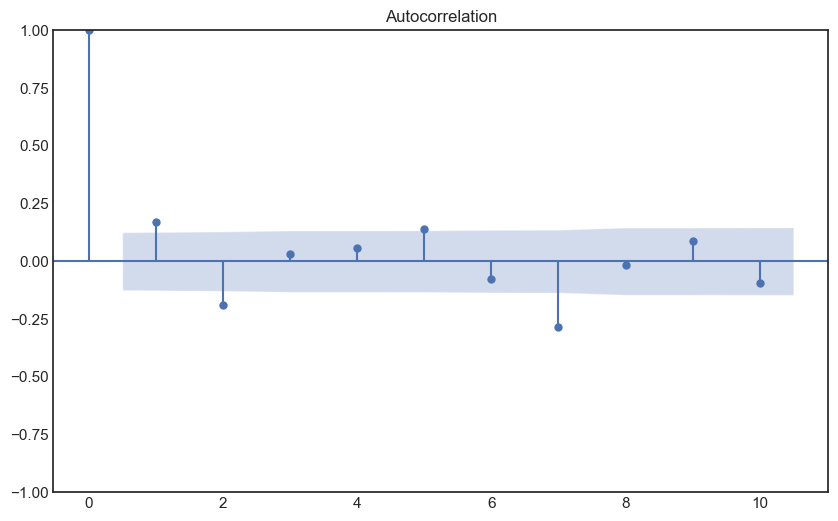

In [76]:
acf = smt.graphics.plot_acf(residuals, lags=10 , alpha=0.05)
acf.show()

In [77]:
mse = mean_squared_error(y_train, train_pred_lasso)

# Approximate AIC using the formula AIC = n * log(MSE) + 2 * k
n = len(y_train)  # Number of observations
k = np.count_nonzero(lasso_best.coef_) + 1  # Number of non-zero coefficients + intercept

aic = n * np.log(mse) + 2 * k
print("Best Alpha:", lasso_best.alpha)
print("MSE:", mse)
print("AIC Approximation:", aic)

Best Alpha: 0.024547827436845415
MSE: 0.6297050831582311
AIC Approximation: -101.7759080280455


In [78]:
#model_stats_df = model_results('lasso_test', y_test, test_pred_lasso, X_test_trf.shape[0], X_test_trf.shape[1] , model_stats_df )

lasso_stats_df = model_results('ffef_tr_train', train0_df['FEDFUNDS'], train0_df['ffef_tr'], 0, None)
#lasso_stats_df = model_results('ffef_tr_test', test0_df['FEDFUNDS'], test0_df['ffef_tr'], 0, lasso_stats_df)
                              
lasso_stats_df = model_results('ffef_tr2_train', train0_df['FEDFUNDS'], train0_df['ffef_tr2'], 0, lasso_stats_df )
#lasso_stats_df = model_results('ffef_tr2_test', test0_df['FEDFUNDS'], test0_df['ffef_tr2'], 0, lasso_stats_df )     

lasso_stats_df = model_results('lasso_train', y_train, train_pred_lasso, aic , lasso_stats_df )
#lasso_stats_df = model_results('lasso_test', y_test, test_pred_lasso, 0 , lasso_stats_df )

lasso_stats_df

,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,31.7498,5.6347,9.9857,4.9215,0
1,ffef_tr2_train,0.9629,0.9813,0.8930,0.6269,0
2,lasso_train,0.6297,0.7935,0.4205,0.4750,-101.7759


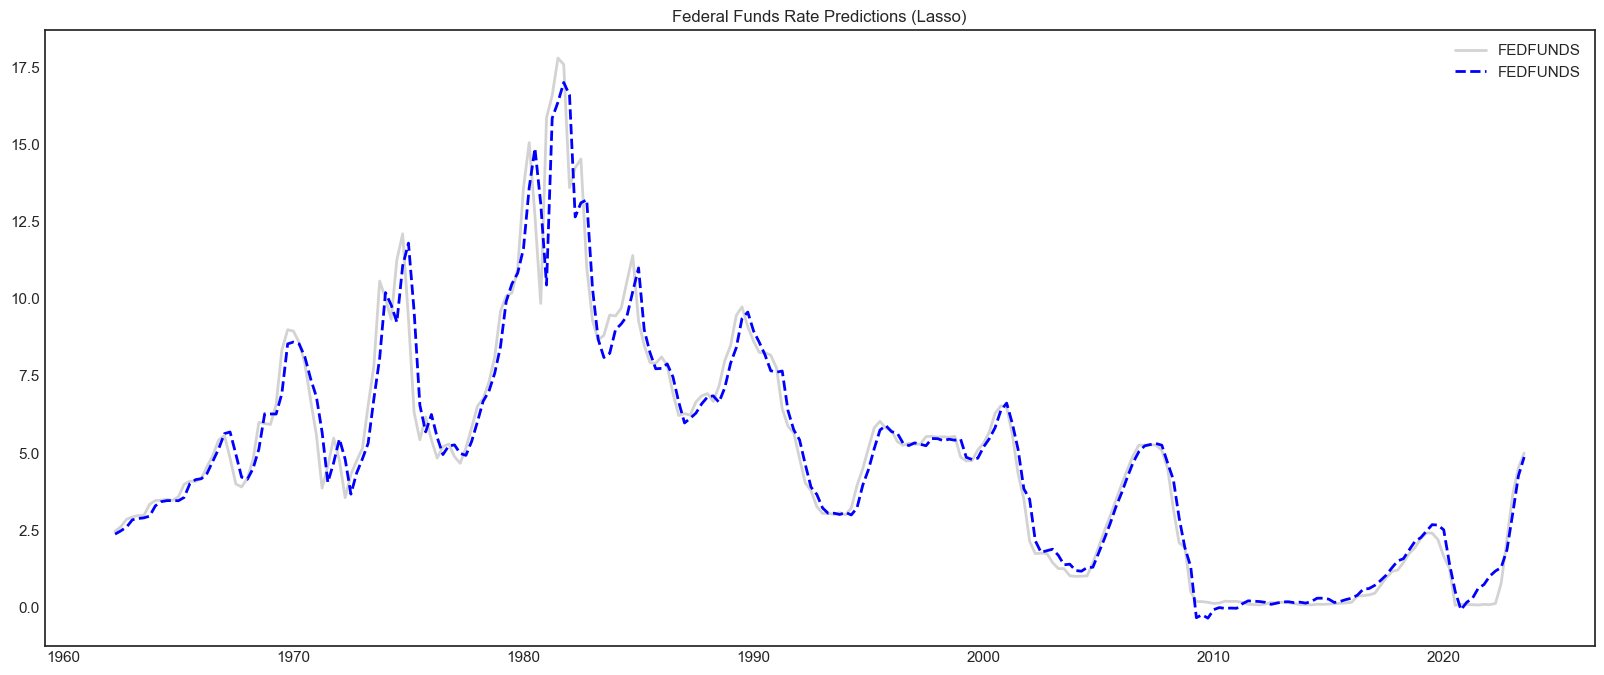

In [79]:
# Graph
fig, ax = plt.subplots(figsize=(20,8))
ax.xaxis.grid(False)

# Plot
ax.plot(train_df.index, train_df['FEDFUNDS'], 'lightgray', linewidth=2)
#ax.plot(test_df.index, test_df['FEDFUNDS'], 'lightgray', linewidth=2)
ax.plot(train_df.index, train_pred_lasso, color='blue', linestyle='--', linewidth=2)
#ax.plot(test_df.index, test_pred_lasso, color='red', linestyle='--', linewidth=2)

ax.legend(["FEDFUNDS", "FEDFUNDS","train_pred_lasso","test_pred_lasso"])
ax.set(title='Federal Funds Rate Predictions (Lasso)');

plt.show()

# Result - Lasso

In [80]:
lasso_stats_df

,name,mse,rmse,mape,mae,aic
0,ffef_tr_train,31.7498,5.6347,9.9857,4.9215,0
1,ffef_tr2_train,0.9629,0.9813,0.8930,0.6269,0
2,lasso_train,0.6297,0.7935,0.4205,0.4750,-101.7759


## Sharpe

In [81]:
model = cv.best_estimator_.named_steps.model
model

LassoCV(cv=5, max_iter=10000, random_state=12, verbose=0)

In [82]:
explainer = None
shap_values = None

In [83]:
try:
    explainer = shap.Explainer(lasso_best, X_train_trf)
    shap_values = explainer(X_train_trf)
except Exception as e:
    print('-- error ')
    print(e)

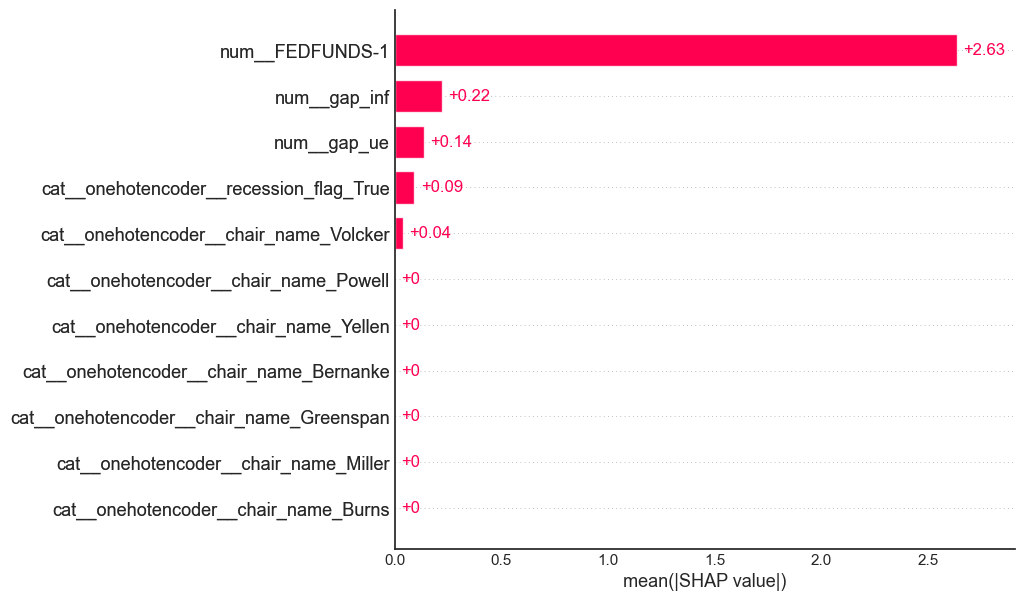

In [84]:
if (shap_values is not None):
    shap.plots.bar(shap_values, max_display=20)

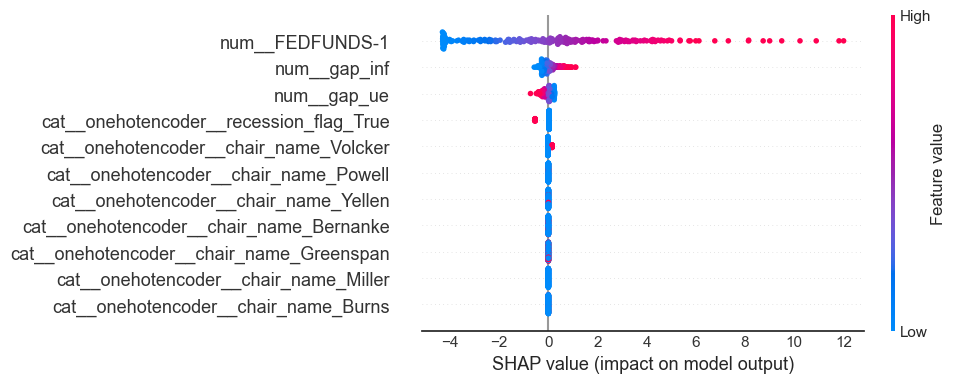

In [85]:
if (shap_values is not None):
    shap.summary_plot(shap_values, X_train_trf, plot_size=(10,4))

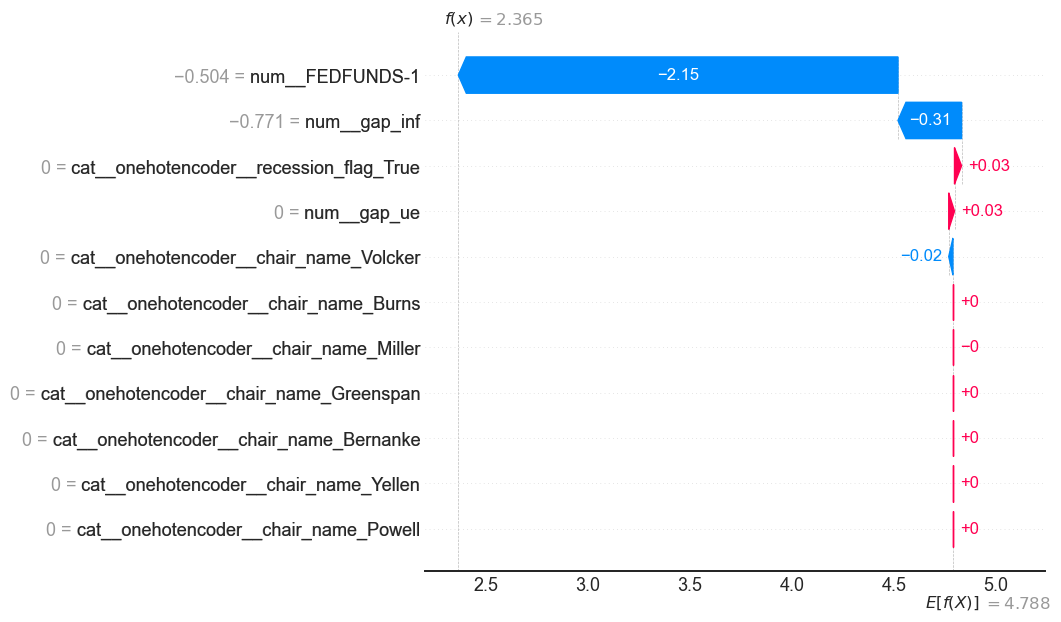

In [86]:
if (shap_values is not None):
    shap.plots.waterfall(shap_values[0], max_display=20)


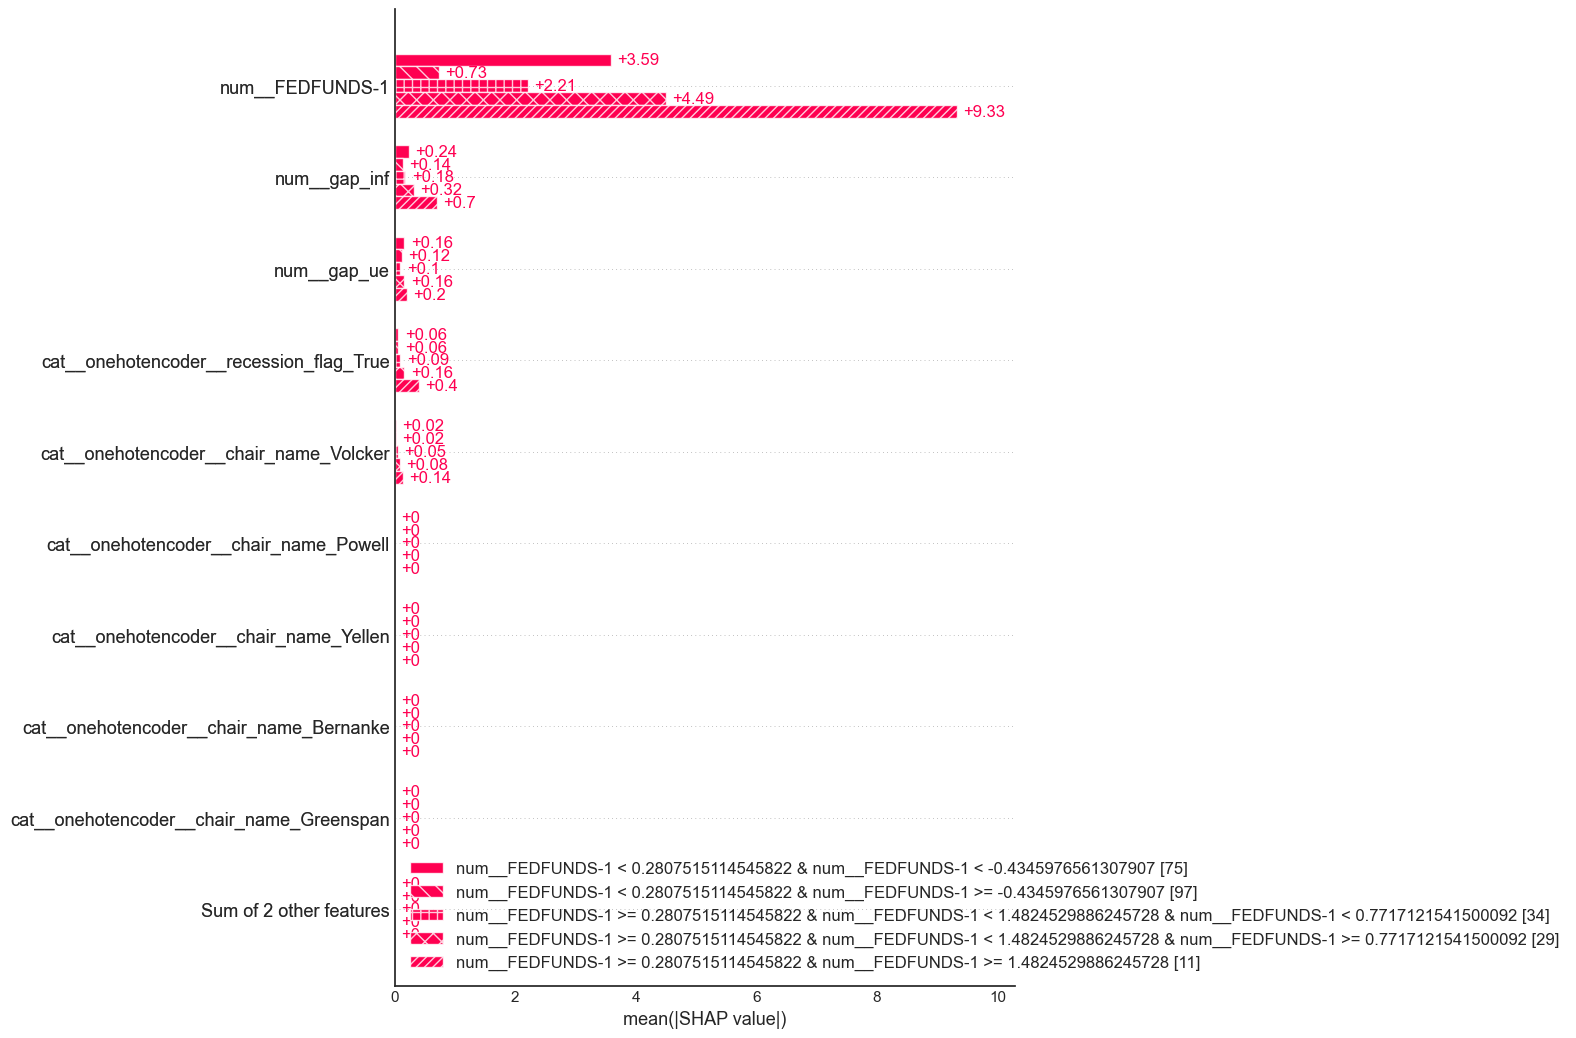

In [87]:
if (shap_values is not None):
    shap.plots.bar(shap_values.cohorts(5).abs.mean(0),  max_display=10)

In [88]:
shap.force_plot(shap_values, plot_cmap = "PkYg")

if (shap_values is not None):
    shap.plots.scatter(shap_values[:,"num__gap_ue"])

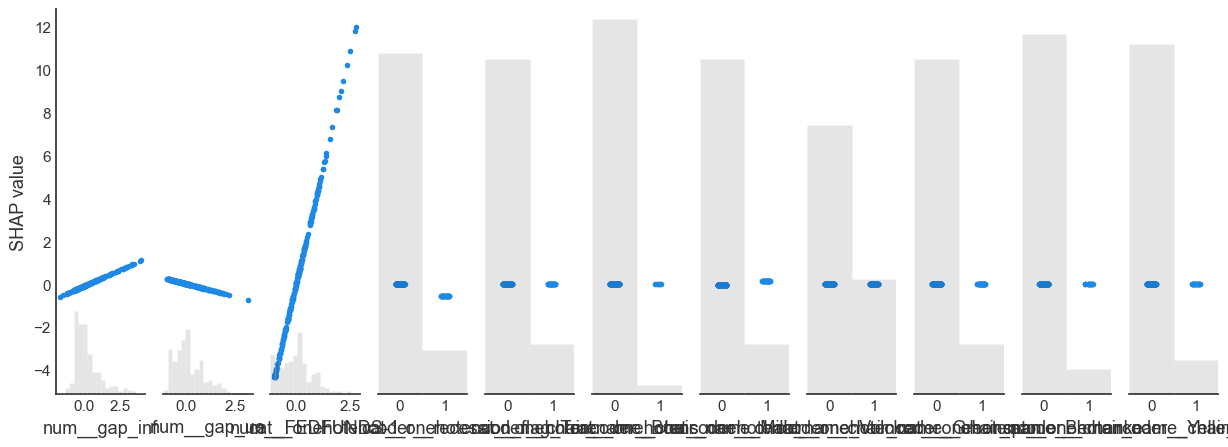

In [89]:
if (shap_values is not None):
    shap.plots.scatter(shap_values)